### Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

from pybaseball import batting_stats, pitching_stats, statcast, statcast_batter, statcast_pitcher, playerid_lookup
from pybaseball import lahman

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from bs4 import BeautifulSoup as BS 
import requests
import json

In [2]:
import matplotlib as mpl 
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
# pip install --upgrade pybaseball
# import pybaseball
# print(pybaseball.__version__)

### Dataset

In [4]:
# batting dataset
batting_22_df = batting_stats(2022,qual=300)
print('2022 batting dataset:',batting_22_df.shape)

#pitching dataset
pitching_22_df = pitching_stats(2022,qual=30)
print('2022 pitching dataset:',pitching_22_df.shape)

2022 batting dataset: (277, 320)
2022 pitching dataset: (470, 393)


In [15]:
# every batting stats columns
# print(batting_22_df.columns.tolist())

In [16]:
# every pitching stats columns
# print(pitching_22_df.columns.tolist())

In [5]:
# stats columns
bat_stats = ['IDfg','Season','Name','Team','Age','G','AB','PA','H','HR','R','RBI','BB','SO','SB','AVG','OBP','SLG','OPS','wOBA','wRC+','WAR']
bat_adv_stats = ['IDfg','Season','Name','Team','Age','G','AB','PA','wOBA','wRC+','WAR','BB%','K%','BB/K','LD%','GB%','FB%',
                 'O-Swing%','Z-Swing%','O-Contact%','Z-Contact%','SwStr%','Pull%','Cent%','Oppo%','Soft%','Med%','Hard%']


pitch_stats = ['IDfg','Season','Name','Team','Age','G','GS','IP','W','L','ERA','WHIP','SO','BB','HR','SV','BS','WAR','K/9','K/BB','HR/9','Start-IP','Relief-IP']
pitch_adv_stats = ['IDfg','Season','Name','Team','Age','G','GS','IP','WAR','ERA','FIP','SIERA','ERA-','K/9','K/BB','K%','BB%','LOB%','LD%','GB%','FB%','HR/FB',
                   'O-Swing%','Z-Swing%','O-Contact%','Z-Contact%','SwStr%','Soft%','Med%','Hard%','Start-IP','Relief-IP']

In [6]:
b_stats = ['IDfg','Season','Name','Team','Age','G','AB','PA','H','HR','R','RBI','BB','SO','SB','AVG','OBP','SLG','OPS','wOBA','wRC+','WAR',
           'BB%','K%','BB/K','LD%','GB%','FB%','O-Swing%','Z-Swing%','O-Contact%','Z-Contact%','SwStr%','Pull%','Cent%','Oppo%','Soft%','Med%','Hard%']
p_stats = ['IDfg','Season','Name','Team','Age','G','GS','IP','W','L','ERA','WHIP','SO','BB','HR','SV','BS','WAR','K/9','K/BB','HR/9',
           'FIP','SIERA','ERA-','K/9','K/BB','K%','BB%','LOB%','LD%','GB%','FB%','HR/FB','O-Swing%','Z-Swing%','O-Contact%','Z-Contact%',
           'SwStr%','Soft%','Med%','Hard%','Start-IP','Relief-IP',]

In [7]:
df_b = batting_stats(2013,2022,qual=300)
df_b = df_b.loc[:,b_stats]
print(df_b.shape)
df_b.head()

(2452, 39)


,IDfg,Season,Name,Team,Age,G,AB,PA,H,HR,...,Z-Swing%,O-Contact%,Z-Contact%,SwStr%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%
1,15640,2022,Aaron Judge,NYY,30,157,570,696,177,62,...,0.676,0.517,0.852,0.118,0.475,0.318,0.208,0.075,0.445,0.480
3,13611,2018,Mookie Betts,BOS,25,136,520,614,180,32,...,0.570,0.707,0.930,0.050,0.472,0.348,0.180,0.122,0.433,0.445
18,10155,2013,Mike Trout,LAA,21,157,589,716,190,27,...,0.556,0.703,0.890,0.066,0.308,0.382,0.310,0.113,0.508,0.380
4,10155,2018,Mike Trout,LAA,26,140,471,608,147,39,...,0.591,0.690,0.917,0.060,0.402,0.373,0.225,0.160,0.396,0.444
0,11579,2015,Bryce Harper,WSN,22,153,521,654,172,42,...,0.725,0.609,0.844,0.108,0.454,0.338,0.208,0.119,0.472,0.409


In [8]:
df_p = pitching_stats(2013,2022,qual=30)
df_p = df_p.loc[:,p_stats]
print(df_p.shape)
df_p.head()

(4212, 43)


,IDfg,Season,Name,Team,Age,G,GS,IP,W,L,...,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,SwStr%,Soft%,Med%,Hard%,Start-IP,Relief-IP
87,10954,2018,Jacob deGrom,NYM,30,32,32,217.0,10,9,...,0.379,0.688,0.577,0.797,0.151,0.252,0.482,0.266,217.0,NaN
210,2036,2015,Clayton Kershaw,LAD,27,33,33,232.2,16,7,...,0.345,0.687,0.513,0.782,0.159,0.199,0.548,0.253,232.2,NaN
100,2036,2014,Clayton Kershaw,LAD,26,27,27,198.1,21,3,...,0.365,0.686,0.556,0.822,0.142,0.245,0.512,0.243,198.1,NaN
775,10603,2017,Chris Sale,BOS,28,32,32,214.1,17,8,...,0.362,0.656,0.557,0.792,0.149,0.185,0.518,0.297,214.1,NaN
432,13125,2019,Gerrit Cole,HOU,28,33,33,212.1,20,5,...,0.350,0.679,0.491,0.771,0.168,0.193,0.468,0.339,212.1,NaN


In [29]:
df_b.to_csv('batting_stats.csv')
df_p.to_csv('pitching_stats.csv')

In [9]:
# batting dataframe
bat_df = batting_22_df.loc[:,bat_stats]
bat_adv_df = batting_22_df.loc[:,bat_adv_stats]

bat_df.sort_values(by='wRC+',ascending=False).head(10)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,HR,...,BB,SO,SB,AVG,OBP,SLG,OPS,wOBA,wRC+,WAR
0,15640,2022,Aaron Judge,NYY,30,157,570,696,177,62,...,111,175,16,0.311,0.425,0.686,1.111,0.458,209,11.6
1,19556,2022,Yordan Alvarez,HOU,25,135,470,561,144,37,...,78,106,1,0.306,0.406,0.613,1.019,0.427,185,6.7
2,9218,2022,Paul Goldschmidt,STL,34,151,561,651,178,35,...,79,141,7,0.317,0.404,0.578,0.981,0.419,176,7.0
3,10155,2022,Mike Trout,LAA,30,119,438,499,124,40,...,54,139,1,0.283,0.369,0.630,0.999,0.418,176,6.0
4,5417,2022,Jose Altuve,HOU,32,141,527,604,158,28,...,66,87,18,0.300,0.387,0.533,0.921,0.397,164,6.6
5,5361,2022,Freddie Freeman,LAD,32,159,612,708,199,21,...,84,102,13,0.325,0.407,0.511,0.918,0.393,158,7.1
6,11493,2022,Manny Machado,SDP,29,150,578,644,172,32,...,63,133,9,0.298,0.366,0.531,0.898,0.382,153,7.5
7,9777,2022,Nolan Arenado,STL,31,148,557,620,163,30,...,52,72,5,0.293,0.358,0.533,0.891,0.381,150,7.2
8,1177,2022,Albert Pujols,STL,42,109,307,351,83,24,...,28,55,1,0.270,0.345,0.550,0.895,0.380,149,1.7
12,11899,2022,Joc Pederson,SFG,30,134,380,433,104,23,...,42,100,3,0.274,0.353,0.521,0.874,0.373,146,2.1


In [10]:
# pitching dataframe
pitch_df = pitching_22_df.loc[:,pitch_stats]
pitch_adv_df = pitching_22_df.loc[:,pitch_adv_stats]

# starting pitching dataframe
sp_df = pitch_df.loc[(pitch_df['GS'] >= 5) & ((pitch_df['Start-IP'] > 50) | (pitch_df['Relief-IP'] < 20))]
sp_adv_df = pitch_adv_df.loc[(pitch_adv_df['GS'] >= 5) & ((pitch_adv_df['Start-IP'] > 50) | (pitch_adv_df['Relief-IP'] < 20))]

# relief pitching dataframe
rp_df = pitch_df.loc[(pitch_df['GS'] < 5) & ((pitch_df['Start-IP'] < 10) | (pitch_df['Relief-IP'] > 10))]
rp_adv_df = pitch_adv_df.loc[(pitch_adv_df['GS'] < 5) & ((pitch_adv_df['Start-IP'] < 10) | (pitch_adv_df['Relief-IP'] > 10))]

sp_df.sort_values(by='ERA').head(10)

,IDfg,Season,Name,Team,Age,G,GS,IP,W,L,...,BB,HR,SV,BS,WAR,K/9,K/BB,HR/9,Start-IP,Relief-IP
10,8700,2022,Justin Verlander,HOU,39,28,28,175.0,18,4,...,29,12,0,0,6.0,9.51,6.38,0.62,175.0,NaN
27,19388,2022,Tony Gonsolin,LAD,28,24,24,130.1,16,1,...,35,11,0,0,2.7,8.22,3.40,0.76,130.1,NaN
29,14765,2022,Julio Urias,LAD,25,31,31,175.0,17,7,...,41,23,0,0,3.2,8.54,4.05,1.18,175.0,NaN
34,18525,2022,Dylan Cease,CHW,26,32,32,184.0,14,8,...,78,16,0,0,4.4,11.10,2.91,0.78,184.0,NaN
38,26410,2022,Alek Manoah,TOR,24,31,31,196.2,16,7,...,51,16,0,0,4.1,8.24,3.53,0.73,196.2,NaN
44,18684,2022,Sandy Alcantara,MIA,26,32,32,228.2,14,9,...,50,16,0,0,5.8,8.15,4.14,0.63,228.2,NaN
43,2036,2022,Clayton Kershaw,LAD,34,22,22,126.1,12,3,...,23,10,0,0,3.8,9.76,5.96,0.71,126.1,NaN
45,3137,2022,Max Scherzer,NYM,37,23,23,145.1,11,5,...,24,13,0,0,4.4,10.71,7.21,0.81,145.1,NaN
48,19755,2022,Shohei Ohtani,LAA,27,28,28,166.0,15,9,...,44,14,0,0,5.6,11.87,4.98,0.76,166.0,NaN
51,17874,2022,Nestor Cortes,NYY,27,28,28,158.1,12,4,...,38,16,0,0,3.6,9.27,4.29,0.91,158.1,NaN


### Batting Stats

In [11]:
# qualified batters with a batting average over .300
bat_df[['Name','Team','Age','AVG']].loc[(bat_df['PA']>=502)&(bat_df['AVG']>=.3)].sort_values(by='AVG',ascending=False,ignore_index=True)

,Name,Team,Age,AVG
0,Jeff McNeil,NYM,30,0.326
1,Freddie Freeman,LAD,32,0.325
2,Paul Goldschmidt,STL,34,0.317
3,Luis Arraez,MIN,25,0.316
4,Aaron Judge,NYY,30,0.311
5,Xander Bogaerts,BOS,29,0.307
6,Yordan Alvarez,HOU,25,0.306
7,Jose Abreu,CHW,35,0.304
8,Andrew Benintendi,- - -,27,0.304
9,Nathaniel Lowe,TEX,26,0.302


In [12]:
# batters with 30+ home runs
bat_df[['Name','Team','Age','HR']].loc[bat_df['HR']>=30].sort_values(by='HR',ascending=False,ignore_index=True)

,Name,Team,Age,HR
0,Aaron Judge,NYY,30,62
1,Kyle Schwarber,PHI,29,46
2,Mike Trout,LAA,30,40
3,Pete Alonso,NYM,27,40
4,Austin Riley,ATL,25,38
5,Yordan Alvarez,HOU,25,37
6,Christian Walker,ARI,31,36
7,Mookie Betts,LAD,29,35
8,Paul Goldschmidt,STL,34,35
9,Rowdy Tellez,MIL,27,35


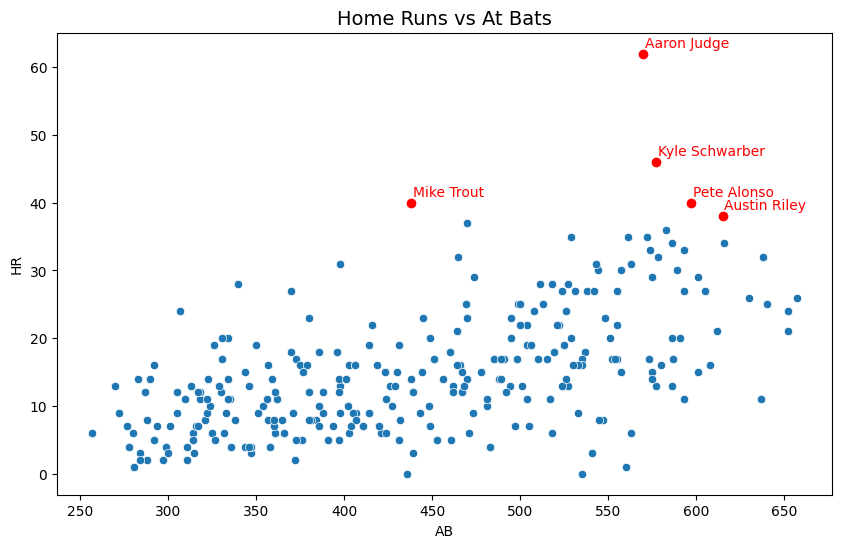

In [41]:
# scatterplot of home runs vs at bats
fig, ax = plt.subplots(figsize=(10,6))
top_5 = bat_df[['Name','HR']].sort_values(by='HR',ascending=False).head(5)
players = top_5['Name']

sns.scatterplot(data=bat_df,x='AB',y='HR')
ax.set_title('Home Runs vs At Bats',fontsize=14)

for player_name in players:
    player = bat_df.loc[bat_df['Name'] == player_name]
    
    if not player.empty:
        ab = player['AB']
        homerun = player['HR']
        
        ax.annotate(player_name,xy=(ab+1,homerun+1),color='red',fontsize=10)
        ax.scatter(ab,homerun,color='red');

In [14]:
# qualified batters with 140+ wRC+
bat_df[['Name','Team','Age','wRC+']].loc[(bat_df['PA']>=502)&(bat_df['wRC+']>=140)].sort_values(by='wRC+',ascending=False,ignore_index=True)

,Name,Team,Age,wRC+
0,Aaron Judge,NYY,30,209
1,Yordan Alvarez,HOU,25,185
2,Paul Goldschmidt,STL,34,176
3,Jose Altuve,HOU,32,164
4,Freddie Freeman,LAD,32,158
5,Manny Machado,SDP,29,153
6,Nolan Arenado,STL,31,150
7,Yandy Diaz,TBR,30,146
8,Julio Rodriguez,SEA,21,146
9,Juan Soto,- - -,23,145


In [15]:
# qualified batters with an OPS over .850
bat_df[['Name','Team','Age','OPS']].loc[(bat_df['PA']>=502)&(bat_df['OPS']>=.85)].sort_values(by='OPS',ascending=False,ignore_index=True)

,Name,Team,Age,OPS
0,Aaron Judge,NYY,30,1.111
1,Yordan Alvarez,HOU,25,1.019
2,Paul Goldschmidt,STL,34,0.981
3,Jose Altuve,HOU,32,0.921
4,Freddie Freeman,LAD,32,0.918
5,Manny Machado,SDP,29,0.898
6,Nolan Arenado,STL,31,0.891
7,Rafael Devers,BOS,25,0.879
8,Austin Riley,ATL,25,0.878
9,Shohei Ohtani,LAA,27,0.875


In [16]:
# batters with 20+ stolen bases
bat_df[['Name','Team','Age','SB']].loc[bat_df['SB']>=20].sort_values(by='SB',ascending=False,ignore_index=True)

,Name,Team,Age,SB
0,Jon Berti,MIA,32,41
1,Jorge Mateo,BAL,27,35
2,Cedric Mullins II,BAL,27,34
3,Randy Arozarena,TBR,27,32
4,Tommy Edman,STL,27,32
5,Bobby Witt Jr.,KCR,22,30
6,Ronald Acuna Jr.,ATL,24,29
7,Trea Turner,LAD,29,27
8,Julio Rodriguez,SEA,21,25
9,Kyle Tucker,HOU,25,25


In [17]:
# HR, OPS, wRC+ for players with 6+ WAR
bat_df[['Name','Team','Age','HR','OPS','wRC+','WAR']].loc[bat_df['WAR']>=6].sort_values(by='WAR',ascending=False,ignore_index=True)

,Name,Team,Age,HR,OPS,wRC+,WAR
0,Aaron Judge,NYY,30,62,1.111,209,11.6
1,Manny Machado,SDP,29,32,0.898,153,7.5
2,Nolan Arenado,STL,31,30,0.891,150,7.2
3,Freddie Freeman,LAD,32,21,0.918,158,7.1
4,Paul Goldschmidt,STL,34,35,0.981,176,7.0
5,Yordan Alvarez,HOU,25,37,1.019,185,6.7
6,Jose Altuve,HOU,32,28,0.921,164,6.6
7,Mookie Betts,LAD,29,35,0.873,145,6.6
8,Francisco Lindor,NYM,28,26,0.788,125,6.6
9,J.T. Realmuto,PHI,31,22,0.820,128,6.5


In [18]:
# qualified batters with strikeout rate over 25%
bat_adv_df[['Name','Team','Age','K%']].loc[(bat_adv_df['PA']>=502)&(bat_adv_df['K%']>=.25)].sort_values(by='K%',ascending=False,ignore_index=True)

,Name,Team,Age,K%
0,Patrick Wisdom,CHC,30,0.343
1,Luke Voit,- - -,31,0.315
2,Eugenio Suarez,SEA,30,0.312
3,Kyle Schwarber,PHI,29,0.299
4,Trent Grisham,SDP,25,0.286
5,Teoscar Hernandez,TOR,29,0.284
6,Adolis Garcia,TEX,29,0.279
7,Jorge Mateo,BAL,27,0.276
8,Matt Chapman,TOR,29,0.274
9,Cody Bellinger,LAD,26,0.273


In [19]:
# top 10 walk rate among qualified batters
bat_adv_df[['Name','Team','Age','BB%']].loc[bat_adv_df['PA']>=502].sort_values(by='BB%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,BB%
0,Juan Soto,- - -,23,0.203
1,Aaron Judge,NYY,30,0.159
2,Max Muncy,LAD,31,0.159
3,Jesse Winker,SEA,28,0.154
4,Carlos Santana,- - -,36,0.140
5,Yandy Diaz,TBR,30,0.140
6,Yordan Alvarez,HOU,25,0.139
7,Alex Bregman,HOU,28,0.133
8,Christian Yelich,MIL,30,0.131
9,Kyle Schwarber,PHI,29,0.129


In [20]:
# top 10 BB/K ratio among qualified batters
bat_adv_df[['Name','Team','Age','BB/K']].loc[bat_adv_df['PA']>=502].sort_values(by='BB/K',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,BB/K
0,Juan Soto,- - -,23,1.41
1,Yandy Diaz,TBR,30,1.30
2,Luis Arraez,MIN,25,1.16
3,Alex Bregman,HOU,28,1.13
4,Alejandro Kirk,TOR,23,1.09
5,Steven Kwan,CLE,24,1.03
6,DJ LeMahieu,NYY,33,0.94
7,J.P. Crawford,SEA,27,0.85
8,Jose Ramirez,CLE,29,0.84
9,Jesse Winker,SEA,28,0.82


In [21]:
# top 10 swinging strike percentage among qualified batters
bat_adv_df[['Name','Team','Age','SwStr%']].loc[bat_adv_df['PA']>=502].sort_values(by='SwStr%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,SwStr%
0,Luke Voit,- - -,31,0.187
1,Javier Baez,DET,29,0.186
2,Nick Castellanos,PHI,30,0.170
3,Adolis Garcia,TEX,29,0.168
4,Patrick Wisdom,CHC,30,0.161
5,Jeremy Pena,HOU,24,0.157
6,Teoscar Hernandez,TOR,29,0.156
7,Ryan Mountcastle,BAL,25,0.155
8,Jorge Mateo,BAL,27,0.154
9,Nelson Cruz,WSN,41,0.150


In [22]:
# lowest 10 outside swing percentage among qualified batters
bat_adv_df[['Name','Team','Age','O-Swing%']].loc[bat_adv_df['PA']>=502].sort_values(by='O-Swing%',ignore_index=True).head(10)

,Name,Team,Age,O-Swing%
0,Juan Soto,- - -,23,0.199
1,Max Muncy,LAD,31,0.212
2,Alex Bregman,HOU,28,0.218
3,Jesse Winker,SEA,28,0.223
4,Josh Rojas,ARI,28,0.225
5,Matt Chapman,TOR,29,0.230
6,Trent Grisham,SDP,25,0.230
7,Yandy Diaz,TBR,30,0.231
8,Myles Straw,CLE,27,0.234
9,Steven Kwan,CLE,24,0.234


In [23]:
# top 10 zone contact percentage among qualified batters
bat_adv_df[['Name','Team','Age','Z-Contact%']].loc[bat_adv_df['PA']>=502].sort_values(by='Z-Contact%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Z-Contact%
0,Luis Arraez,MIN,25,0.960
1,Miguel Rojas,MIA,33,0.959
2,Isiah Kiner-Falefa,NYY,27,0.956
3,Steven Kwan,CLE,24,0.954
4,Myles Straw,CLE,27,0.939
5,Mookie Betts,LAD,29,0.939
6,Nico Hoerner,CHC,25,0.939
7,Yuli Gurriel,HOU,38,0.937
8,Tony Kemp,OAK,30,0.936
9,Alex Verdugo,BOS,26,0.933


In [24]:
# top 10 hard hit percentage among qualified batters
bat_adv_df[['Name','Team','Age','Hard%']].loc[bat_adv_df['PA']>=502].sort_values(by='Hard%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Hard%
0,Aaron Judge,NYY,30,0.480
1,Yordan Alvarez,HOU,25,0.442
2,Teoscar Hernandez,TOR,29,0.438
3,Max Muncy,LAD,31,0.410
4,Rowdy Tellez,MIL,27,0.404
5,Matt Chapman,TOR,29,0.402
6,Ryan McMahon,COL,27,0.396
7,Austin Riley,ATL,25,0.395
8,Matt Olson,ATL,28,0.393
9,Adolis Garcia,TEX,29,0.393


### Pitching Stats

**Starting Pitchers**

In [25]:
# qualified starting pitchers with a sub-3.00 ERA
sp_df[['Name','Team','Age','ERA']].loc[(sp_df['IP']>=162)&(sp_df['ERA']<3.0)].sort_values(by='ERA',ignore_index=True)

,Name,Team,Age,ERA
0,Justin Verlander,HOU,39,1.75
1,Julio Urias,LAD,25,2.16
2,Dylan Cease,CHW,26,2.20
3,Alek Manoah,TOR,24,2.24
4,Sandy Alcantara,MIA,26,2.28
5,Shohei Ohtani,LAA,27,2.33
6,Max Fried,ATL,28,2.48
7,Shane McClanahan,TBR,25,2.54
8,Zac Gallen,ARI,26,2.54
9,Tyler Anderson,LAD,32,2.57


In [26]:
# starting pitchers with 200+ strikeouts
sp_df[['Name','Team','Age','SO']].loc[sp_df['SO']>=200].sort_values(by='SO',ascending=False,ignore_index=True)

,Name,Team,Age,SO
0,Gerrit Cole,NYY,31,257
1,Corbin Burnes,MIL,27,243
2,Carlos Rodon,SFG,29,237
3,Aaron Nola,PHI,29,235
4,Dylan Cease,CHW,26,227
5,Shohei Ohtani,LAA,27,219
6,Robbie Ray,SEA,30,212
7,Sandy Alcantara,MIA,26,207
8,Kevin Gausman,TOR,31,205
9,Charlie Morton,ATL,38,205


In [27]:
# starting pitchers with 15+ wins
sp_df[['Name','Team','Age','W']].loc[sp_df['W']>=15].sort_values(by='W',ascending=False,ignore_index=True)

,Name,Team,Age,W
0,Kyle Wright,ATL,26,21
1,Justin Verlander,HOU,39,18
2,Framber Valdez,HOU,28,17
3,Julio Urias,LAD,25,17
4,Alek Manoah,TOR,24,16
5,Yu Darvish,SDP,35,16
6,Tony Gonsolin,LAD,28,16
7,Shohei Ohtani,LAA,27,15
8,Logan Webb,SFG,25,15
9,Tyler Anderson,LAD,32,15


In [28]:
# qualified starting pitchers with a sub-1.00 WHIP
sp_df[['Name','Team','Age','WHIP']].loc[(sp_df['IP']>=162)&(sp_df['WHIP']<1)].sort_values(by='WHIP',ignore_index=True)

,Name,Team,Age,WHIP
0,Justin Verlander,HOU,39,0.83
1,Zac Gallen,ARI,26,0.91
2,Shane McClanahan,TBR,25,0.93
3,Yu Darvish,SDP,35,0.95
4,Triston McKenzie,CLE,24,0.95
5,Aaron Nola,PHI,29,0.96
6,Julio Urias,LAD,25,0.96
7,Corbin Burnes,MIL,27,0.97
8,Sandy Alcantara,MIA,26,0.98
9,Alek Manoah,TOR,24,0.99


In [29]:
# top 10 ERA- among qualified starting pitchers
sp_adv_df[['Name','Team','Age','ERA-']].loc[(sp_adv_df['IP']>=162)].sort_values(by='ERA-',ignore_index=True).head(10)

,Name,Team,Age,ERA-
0,Justin Verlander,HOU,39,45
1,Julio Urias,LAD,25,55
2,Sandy Alcantara,MIA,26,56
3,Dylan Cease,CHW,26,56
4,Shohei Ohtani,LAA,27,59
5,Alek Manoah,TOR,24,59
6,Max Fried,ATL,28,60
7,Zac Gallen,ARI,26,63
8,Tyler Anderson,LAD,32,65
9,Shane McClanahan,TBR,25,69


In [30]:
# top 10 K/9 rate among qualified starting pitchers
sp_adv_df[['Name','Team','Age','K/9']].loc[(sp_adv_df['IP']>=162)].sort_values(by='K/9',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,K/9
0,Carlos Rodon,SFG,29,11.98
1,Shohei Ohtani,LAA,27,11.87
2,Gerrit Cole,NYY,31,11.53
3,Dylan Cease,CHW,26,11.10
4,Corbin Burnes,MIL,27,10.83
5,Charlie Morton,ATL,38,10.73
6,Kevin Gausman,TOR,31,10.56
7,Shane McClanahan,TBR,25,10.50
8,Aaron Nola,PHI,29,10.32
9,Robbie Ray,SEA,30,10.10


In [31]:
# top 10 K/BB ratio among qualified starting pitchers
sp_adv_df[['Name','Team','Age','K/BB']].loc[(sp_adv_df['IP']>=162)].sort_values(by='K/BB',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,K/BB
0,Aaron Nola,PHI,29,8.10
1,Kevin Gausman,TOR,31,7.32
2,Corey Kluber,TBR,36,6.62
3,Justin Verlander,HOU,39,6.38
4,Shane Bieber,CLE,27,5.50
5,Yu Darvish,SDP,35,5.32
6,Max Fried,ATL,28,5.31
7,Gerrit Cole,NYY,31,5.14
8,Shane McClanahan,TBR,25,5.11
9,Shohei Ohtani,LAA,27,4.98


In [32]:
# top 10 LOB% among qualified starting pitchers
sp_adv_df[['Name','Team','Age','LOB%']].loc[(sp_adv_df['IP']>=162)].sort_values(by='LOB%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,LOB%
0,Julio Urias,LAD,25,0.867
1,Shohei Ohtani,LAA,27,0.831
2,Alek Manoah,TOR,24,0.826
3,Dylan Cease,CHW,26,0.823
4,Robbie Ray,SEA,30,0.812
5,Shane McClanahan,TBR,25,0.805
6,Justin Verlander,HOU,39,0.805
7,Triston McKenzie,CLE,24,0.803
8,Joe Musgrove,SDP,29,0.798
9,Kyle Wright,ATL,26,0.789


In [33]:
# top 10 groundball percentage among qualified starting pitchers
sp_adv_df[['Name','Team','Age','GB%']].loc[(sp_adv_df['IP']>=162)].sort_values(by='GB%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,GB%
0,Framber Valdez,HOU,28,0.665
1,Logan Webb,SFG,25,0.567
2,Kyle Wright,ATL,26,0.556
3,Sandy Alcantara,MIA,26,0.534
4,Martin Perez,TEX,31,0.514
5,Max Fried,ATL,28,0.512
6,Shane McClanahan,TBR,25,0.502
7,Chris Bassitt,NYM,33,0.488
8,Shane Bieber,CLE,27,0.482
9,German Marquez,COL,27,0.476


In [34]:
# top 10 soft hit percentage among qualified starting pitchers
sp_adv_df[['Name','Team','Age','Soft%']].loc[(sp_adv_df['IP']>=162)].sort_values(by='Soft%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Soft%
0,Chris Bassitt,NYM,33,0.221
1,Sandy Alcantara,MIA,26,0.215
2,Julio Urias,LAD,25,0.214
3,Justin Verlander,HOU,39,0.213
4,Tyler Anderson,LAD,32,0.209
5,Shohei Ohtani,LAA,27,0.203
6,Max Fried,ATL,28,0.199
7,Joe Musgrove,SDP,29,0.198
8,Jose Quintana,- - -,33,0.189
9,Miles Mikolas,STL,33,0.187


In [35]:
# top 10 hard hit percentage among qualifed starting pitchers
sp_adv_df[['Name','Team','Age','Hard%']].loc[(sp_adv_df['IP']>=162)].sort_values(by='Hard%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Hard%
0,Kyle Freeland,COL,29,0.366
1,German Marquez,COL,27,0.361
2,Logan Gilbert,SEA,25,0.354
3,Nick Pivetta,BOS,29,0.342
4,Shane Bieber,CLE,27,0.335
5,Triston McKenzie,CLE,24,0.335
6,Robbie Ray,SEA,30,0.332
7,Cole Irvin,OAK,28,0.321
8,Jameson Taillon,NYY,30,0.317
9,Corbin Burnes,MIL,27,0.316


In [36]:
# top 10 HR/9 rate among qualified starting pitchers
sp_df[['Name','Team','Age','HR/9']].loc[(sp_df['IP']>=162)].sort_values(by='HR/9',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,HR/9
0,Jose Urquidy,HOU,27,1.59
1,Jose Berrios,TOR,28,1.52
2,Robbie Ray,SEA,30,1.52
3,German Marquez,COL,27,1.49
4,Marco Gonzales,SEA,30,1.48
5,Gerrit Cole,NYY,31,1.48
6,Charlie Morton,ATL,38,1.47
7,Nick Pivetta,BOS,29,1.35
8,Jameson Taillon,NYY,30,1.32
9,Jordan Lyles,BAL,31,1.31


In [37]:
# ERA, FIP, SIERA, ERA- for top 15 ERA among qualified starting pitchers
sp_adv_df[['Name','Team','Age','ERA','FIP','SIERA','ERA-']].loc[(sp_adv_df['IP']>=162)].sort_values(by='ERA',ignore_index=True).head(15)

,Name,Team,Age,ERA,FIP,SIERA,ERA-
0,Justin Verlander,HOU,39,1.75,2.49,3.09,45
1,Julio Urias,LAD,25,2.16,3.71,3.66,55
2,Dylan Cease,CHW,26,2.20,3.10,3.48,56
3,Alek Manoah,TOR,24,2.24,3.35,3.85,59
4,Sandy Alcantara,MIA,26,2.28,2.99,3.42,56
5,Shohei Ohtani,LAA,27,2.33,2.40,2.73,59
6,Max Fried,ATL,28,2.48,2.70,3.31,60
7,Shane McClanahan,TBR,25,2.54,3.00,2.82,69
8,Zac Gallen,ARI,26,2.54,3.05,3.32,63
9,Tyler Anderson,LAD,32,2.57,3.31,4.04,65


In [38]:
# strikeouts, walks, K/9, K/BB for top 15 strikeouts among starting pitchers
sp_df[['Name','Team','Age','IP','SO','BB','K/9','K/BB']].sort_values(by='SO',ascending=False,ignore_index=True).head(15)

,Name,Team,Age,IP,SO,BB,K/9,K/BB
0,Gerrit Cole,NYY,31,200.2,257,50,11.53,5.14
1,Corbin Burnes,MIL,27,202.0,243,51,10.83,4.76
2,Carlos Rodon,SFG,29,178.0,237,52,11.98,4.56
3,Aaron Nola,PHI,29,205.0,235,29,10.32,8.10
4,Dylan Cease,CHW,26,184.0,227,78,11.10,2.91
5,Shohei Ohtani,LAA,27,166.0,219,44,11.87,4.98
6,Robbie Ray,SEA,30,189.0,212,62,10.10,3.42
7,Sandy Alcantara,MIA,26,228.2,207,50,8.15,4.14
8,Kevin Gausman,TOR,31,174.2,205,28,10.56,7.32
9,Charlie Morton,ATL,38,172.0,205,63,10.73,3.25


In [39]:
# top 10 WAR among starting pitchers
sp_df[['Name','Team','Age','WAR']].sort_values(by='WAR',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,WAR
0,Aaron Nola,PHI,29,6.3
1,Carlos Rodon,SFG,29,6.2
2,Justin Verlander,HOU,39,6.0
3,Sandy Alcantara,MIA,26,5.8
4,Kevin Gausman,TOR,31,5.7
5,Shohei Ohtani,LAA,27,5.6
6,Max Fried,ATL,28,5.0
7,Spencer Strider,ATL,23,4.9
8,Shane Bieber,CLE,27,4.8
9,Corbin Burnes,MIL,27,4.6


**Relief Pitchers**

In [40]:
# relief pitchers with a sub-2.00 ERA
rp_df[['Name','Team','Age','ERA']].loc[(rp_df['ERA']<2)].sort_values(by='ERA',ignore_index=True)

,Name,Team,Age,ERA
0,Yency Almonte,LAD,28,1.02
1,Evan Phillips,LAD,27,1.14
2,Ryne Stanek,HOU,30,1.15
3,Ryan Helsley,STL,27,1.25
4,Edwin Diaz,NYM,28,1.31
5,Emmanuel Clase,CLE,24,1.36
6,Cionel Perez,BAL,26,1.40
7,Anthony Bass,- - -,34,1.54
8,Jason Adam,TBR,30,1.56
9,Erik Swanson,SEA,28,1.68


In [41]:
# relief pitchers with a sub-1.00 WHIP
rp_df[['Name','Team','Age','WHIP']].loc[(rp_df['WHIP']<1)].sort_values(by='WHIP',ignore_index=True)

,Name,Team,Age,WHIP
0,Emmanuel Clase,CLE,24,0.73
1,Ryan Helsley,STL,27,0.74
2,Evan Phillips,LAD,27,0.76
3,Jason Adam,TBR,30,0.76
4,Paul Sewald,SEA,32,0.77
5,Yency Almonte,LAD,28,0.79
6,Edwin Diaz,NYM,28,0.84
7,Eli Morgan,CLE,26,0.88
8,Andres Munoz,SEA,23,0.89
9,Ryan Pressly,HOU,33,0.89


In [42]:
# top 10 saves
rp_df[['Name','Team','Age','SV']].sort_values(by='SV',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,SV
0,Emmanuel Clase,CLE,24,42
1,Kenley Jansen,ATL,34,41
2,Liam Hendriks,CHW,33,37
3,Jordan Romano,TOR,29,36
4,Josh Hader,- - -,28,36
5,Daniel Bard,COL,37,34
6,Ryan Pressly,HOU,33,33
7,Edwin Diaz,NYM,28,32
8,Taylor Rogers,- - -,31,31
9,Gregory Soto,DET,27,30


In [43]:
# top 10 ERA- among relief pitchers
rp_adv_df[['Name','Team','Age','ERA-']].sort_values(by='ERA-',ignore_index=True).head(10)

,Name,Team,Age,ERA-
0,Yency Almonte,LAD,28,26
1,Evan Phillips,LAD,27,29
2,Ryne Stanek,HOU,30,30
3,Ryan Helsley,STL,27,32
4,Edwin Diaz,NYM,28,34
5,Emmanuel Clase,CLE,24,36
6,Cionel Perez,BAL,26,37
7,Daniel Bard,COL,37,38
8,Anthony Bass,- - -,34,39
9,Jason Adam,TBR,30,42


In [44]:
# top 10 K/9 rate among relief pitchers
rp_df[['Name','Team','Age','K/9']].sort_values(by='K/9',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,K/9
0,Edwin Diaz,NYM,28,17.13
1,Josh Hader,- - -,28,14.58
2,James Karinchak,CLE,26,14.31
3,Jose Alvarado,PHI,27,14.29
4,Devin Williams,MIL,27,14.24
5,Andres Munoz,SEA,23,13.29
6,Liam Hendriks,CHW,33,13.27
7,Bryan Abreu,HOU,25,13.13
8,Alex Vesia,LAD,26,13.09
9,Ryan Helsley,STL,27,13.08


In [45]:
# top 10 K/BB ratio among relief pitchers
rp_df[['Name','Team','Age','K/BB']].sort_values(by='K/BB',ascending=False).head(10)

,Name,Team,Age,K/BB
122,Chris Martin,- - -,36,14.80
94,Joe Mantiply,ARI,31,10.17
5,Emmanuel Clase,CLE,24,7.70
9,Erik Swanson,SEA,28,7.00
4,Edwin Diaz,NYM,28,6.56
57,Andres Munoz,SEA,23,6.40
21,A.J. Minter,ATL,28,6.27
81,Zach Pop,- - -,25,6.25
276,Taylor Clarke,KCR,29,6.00
199,Joe Jimenez,DET,27,5.92


In [46]:
# top 10 LOB% among relief pitchers
rp_adv_df[['Name','Team','Age','LOB%']].sort_values(by='LOB%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,LOB%
0,Yency Almonte,LAD,28,0.959
1,Ryan Helsley,STL,27,0.934
2,David Price,LAD,36,0.933
3,Ryne Stanek,HOU,30,0.919
4,Edwin Diaz,NYM,28,0.904
5,Anthony Bass,- - -,34,0.895
6,Jason Adam,TBR,30,0.894
7,Jhoan Duran,MIN,24,0.893
8,Drew Smith,NYM,28,0.891
9,Adam Ottavino,NYM,36,0.891


In [47]:
# top 10 hard hit percentage among relief pitchers
rp_adv_df[['Name','Team','Age','Hard%']].sort_values(by='Hard%',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,Hard%
0,Cole Sulser,MIA,32,0.421
1,Dinelson Lamet,- - -,29,0.420
2,Robert Stephenson,- - -,29,0.407
3,Ian Kennedy,ARI,37,0.402
4,Alex Colome,COL,33,0.400
5,T.J. McFarland,STL,33,0.397
6,Trent Thornton,TOR,28,0.396
7,Jake Bird,COL,26,0.394
8,Jake McGee,- - -,35,0.381
9,Noe Ramirez,ARI,32,0.378


In [48]:
# top 10 HR/9 rate among relief pitchers
rp_df[['Name','Team','Age','HR/9']].sort_values(by='HR/9',ascending=False,ignore_index=True).head(10)

,Name,Team,Age,HR/9
0,Mike Mayers,LAA,30,2.66
1,Kirk McCarty,CLE,26,2.63
2,Dauri Moreta,CIN,26,2.35
3,Craig Stammen,SDP,38,1.99
4,Ian Kennedy,ARI,37,1.97
5,Caleb Smith,ARI,30,1.80
6,Austin Pruitt,OAK,32,1.79
7,Phil Bickford,LAD,26,1.77
8,Drew Smith,NYM,28,1.76
9,Brandon Hughes,CHC,26,1.72


In [49]:
# ERA, FIP, SIERA, ERA- for top 15 ERA among relief pitchers
rp_adv_df[['Name','Team','Age','ERA','FIP','SIERA','ERA-']].sort_values(by='ERA',ignore_index=True).head(15)

,Name,Team,Age,ERA,FIP,SIERA,ERA-
0,Yency Almonte,LAD,28,1.02,3.17,3.25,26
1,Evan Phillips,LAD,27,1.14,1.94,2.34,29
2,Ryne Stanek,HOU,30,1.15,3.02,3.85,30
3,Ryan Helsley,STL,27,1.25,2.34,2.02,32
4,Edwin Diaz,NYM,28,1.31,0.90,1.11,34
5,Emmanuel Clase,CLE,24,1.36,1.98,1.95,36
6,Cionel Perez,BAL,26,1.40,2.80,3.48,37
7,Anthony Bass,- - -,34,1.54,3.00,3.11,39
8,Jason Adam,TBR,30,1.56,2.86,2.57,42
9,Erik Swanson,SEA,28,1.68,1.85,2.19,45


In [50]:
# strikeouts, walks, K/9, K/BB for top 15 strikeouts among relief pitchers
rp_df[['Name','Team','Age','IP','SO','BB','K/9','K/BB']].sort_values(by='SO',ascending=False,ignore_index=True).head(15)

,Name,Team,Age,IP,SO,BB,K/9,K/BB
0,Edwin Diaz,NYM,28,62.0,118,18,17.13,6.56
1,Devin Williams,MIL,27,60.2,96,30,14.24,3.20
2,Andres Munoz,SEA,23,65.0,96,15,13.29,6.40
3,A.J. Minter,ATL,28,70.0,94,15,12.09,6.27
4,Ryan Helsley,STL,27,64.2,94,20,13.08,4.70
5,Tanner Scott,MIA,27,62.2,90,46,12.93,1.96
6,Brock Burke,TEX,25,82.1,90,24,9.84,3.75
7,Jhoan Duran,MIN,24,67.2,89,16,11.84,5.56
8,Bryan Abreu,HOU,25,60.1,88,26,13.13,3.38
9,Felix Bautista,BAL,27,65.2,88,23,12.06,3.83


### Statcast Data and Data Visualizations

In [12]:
# statcast data from Sept 2022 to end of the season
sc = statcast('2022-09-01','2022-10-05','LAD')
print('{} rows imported'.format(str(len(sc))))

This is a large query, it may take a moment to complete


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]

4629 rows imported


In [52]:
# statcast columns
# print(sc.columns.tolist())

In [53]:
# look up Aaron Judge player id
playerid_lookup('judge')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,judge,aaron,592450,judga001,judgeaa01,15640,2016.0,2023.0
1,judge,joe,116786,judgj101,judgejo01,1006644,1915.0,1934.0


In [13]:
# Judge statcast data
judge = statcast_batter('2022-04-7','2022-10-05',592450)
print('{} rows imported'.format(str(len(judge))))

Gathering Player Data
2906 rows imported


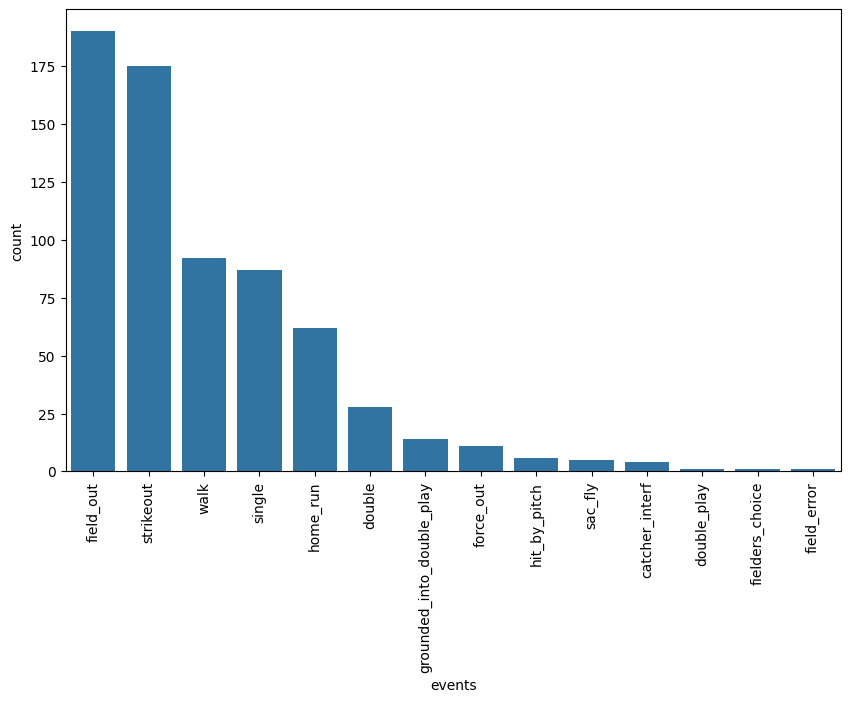

In [39]:
# countplot of the result of every Judge plate appearance
plt.figure(figsize=(10,6))
sns.countplot(data=judge,x='events',order=judge['events'].value_counts().index)
plt.xticks(rotation=90);

In [56]:
# percentages of every type of pitch thrown to Judge
judge['pitch_type'].value_counts(normalize=True)

pitch_type
FF    0.273666
SL    0.205852
SI    0.159036
CH    0.133219
FC    0.079518
CU    0.058864
ST    0.040620
FS    0.024096
KC    0.014458
SV    0.007573
FA    0.002410
EP    0.000688
Name: proportion, dtype: float64

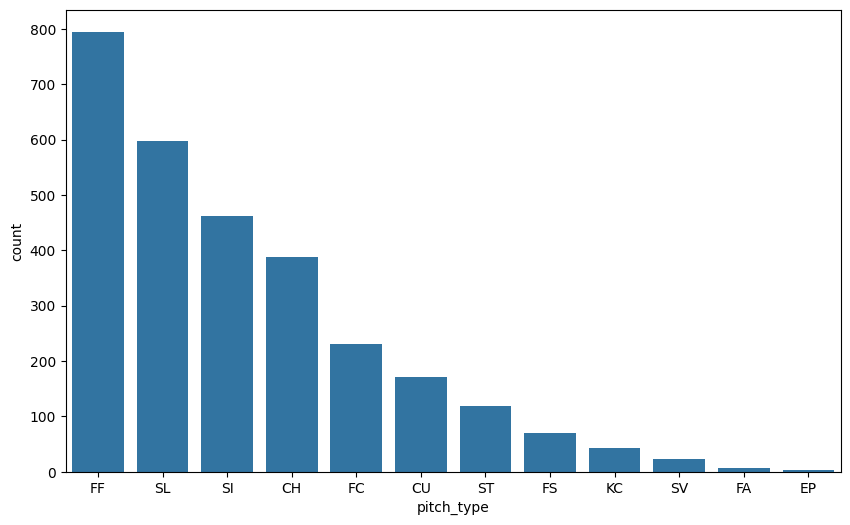

In [44]:
# countplot of every type of pitch thrown to Judge
plt.figure(figsize=(10,6))
sns.countplot(data=judge,x='pitch_type',order=judge['pitch_type'].value_counts().index);

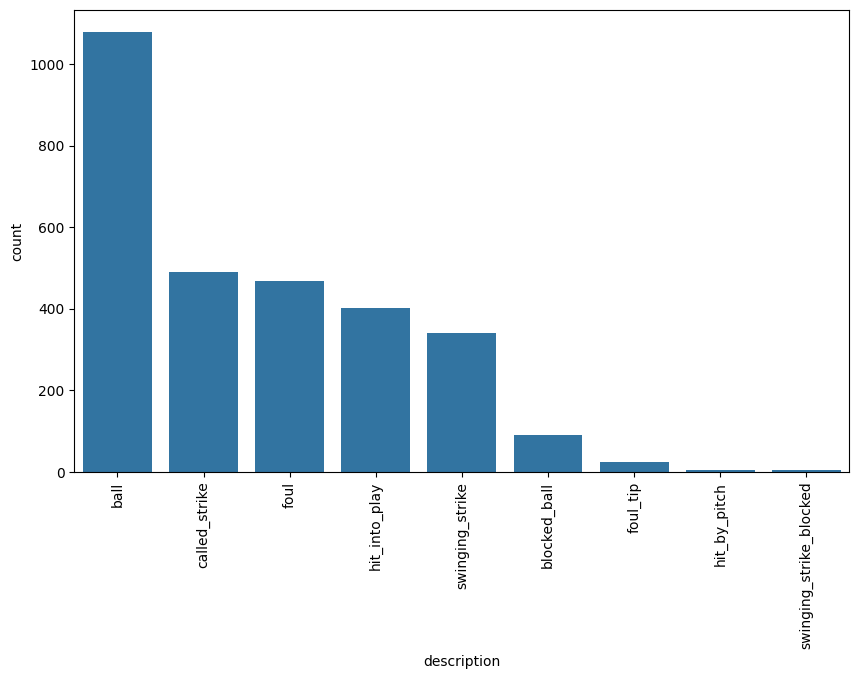

In [45]:
# countplot of the result of every pitch to Judge
plt.figure(figsize=(10,6))
sns.countplot(data=judge,x='description',order=judge['description'].value_counts().index)
plt.xticks(rotation=90);

In [59]:
# percentages of the result of every batted ball by Judge
judge['bb_type'].value_counts(normalize=True)

bb_type
fly_ball       0.3825
ground_ball    0.3700
line_drive     0.2225
popup          0.0250
Name: proportion, dtype: float64

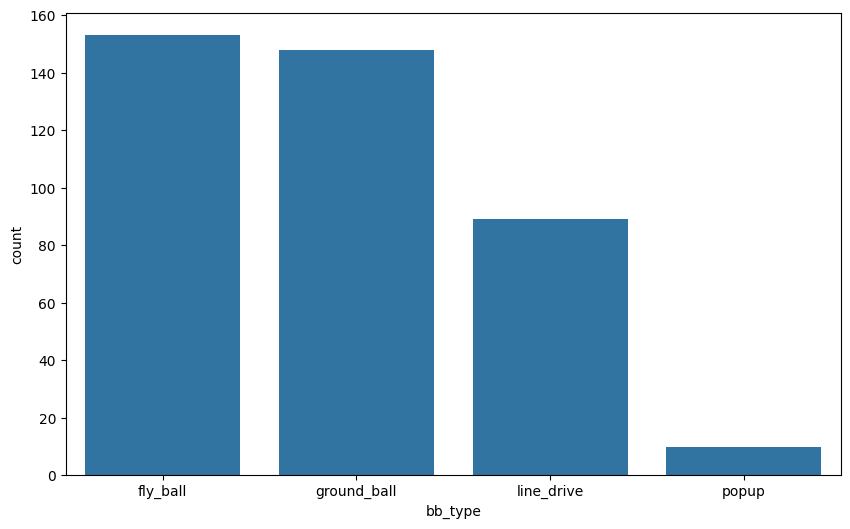

In [46]:
# countplot of the result of every batted ball by Judge
plt.figure(figsize=(10,6))
sns.countplot(data=judge,x='bb_type',order=judge['bb_type'].value_counts().index);

In [61]:
print('Average hit distance:',judge['hit_distance_sc'].mean())

Average hit distance: 171.34143377885783


In [62]:
print('Average exit velocity:',judge['launch_speed'].mean())

Average exit velocity: 86.54259485924113


In [63]:
print('Average launch angle:',judge['launch_angle'].mean())

Average launch angle: 17.991442542787286


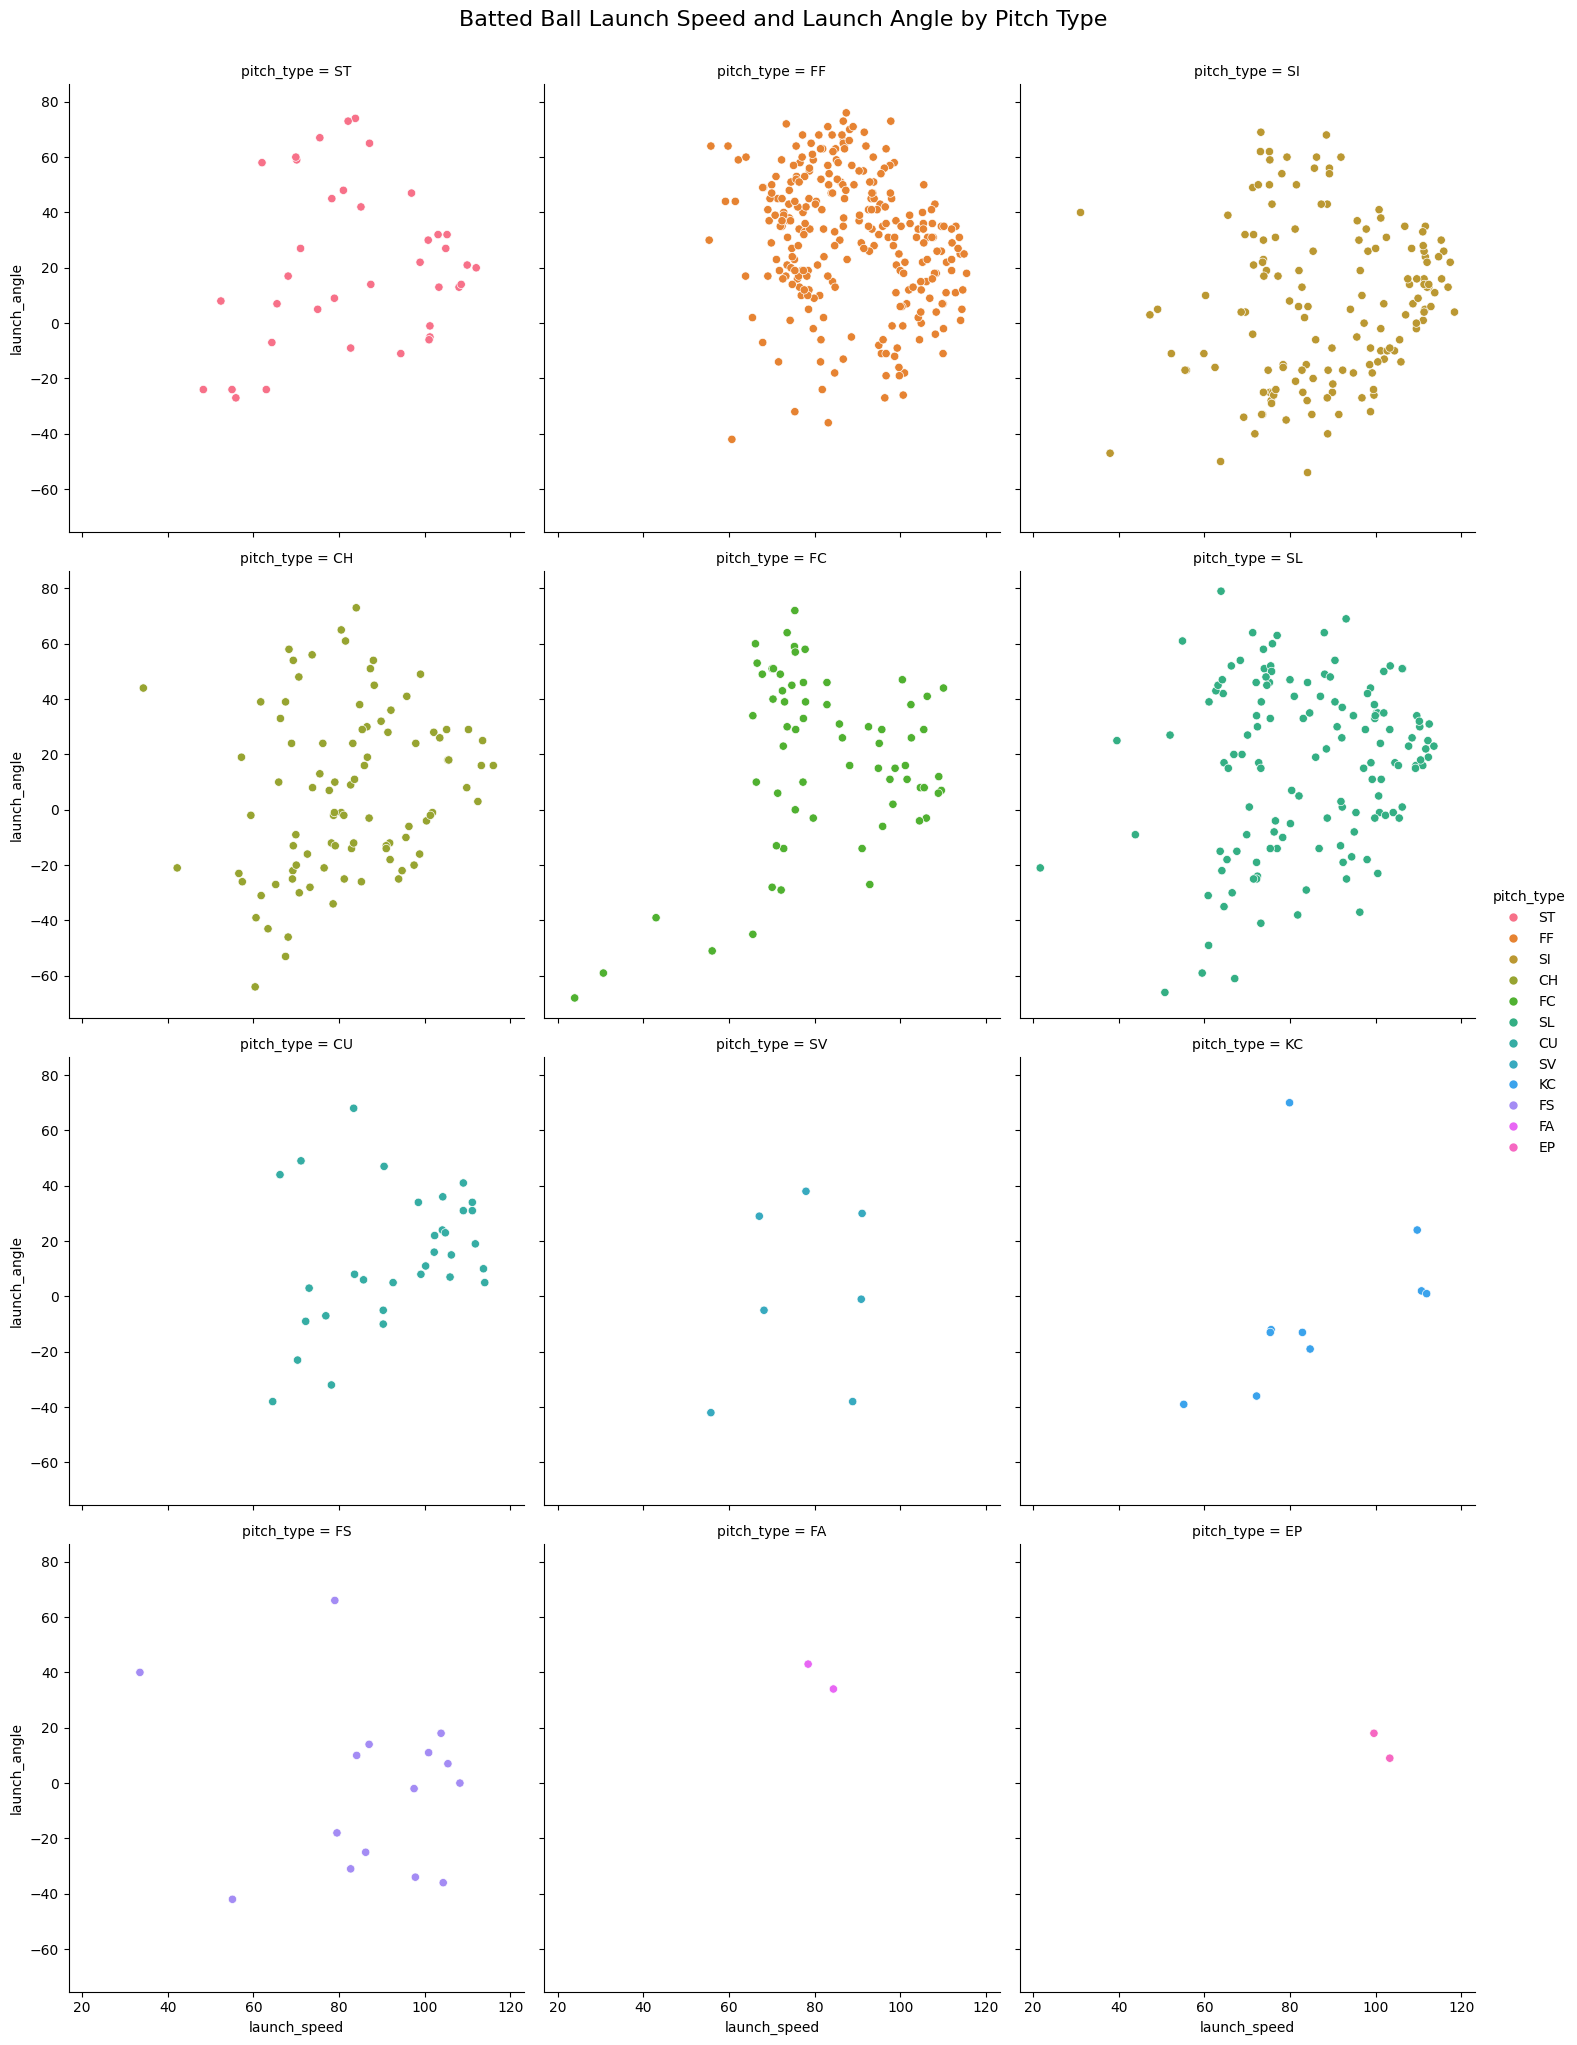

In [47]:
# relplot of batted ball launch speed vs launch angle by pitch type for Judge
sns.relplot(data=judge,x='launch_speed',y='launch_angle',hue='pitch_type',col='pitch_type',col_wrap=3,height=5)
plt.suptitle('Batted Ball Launch Speed and Launch Angle by Pitch Type',ha='center',y=1.02,fontsize=16);

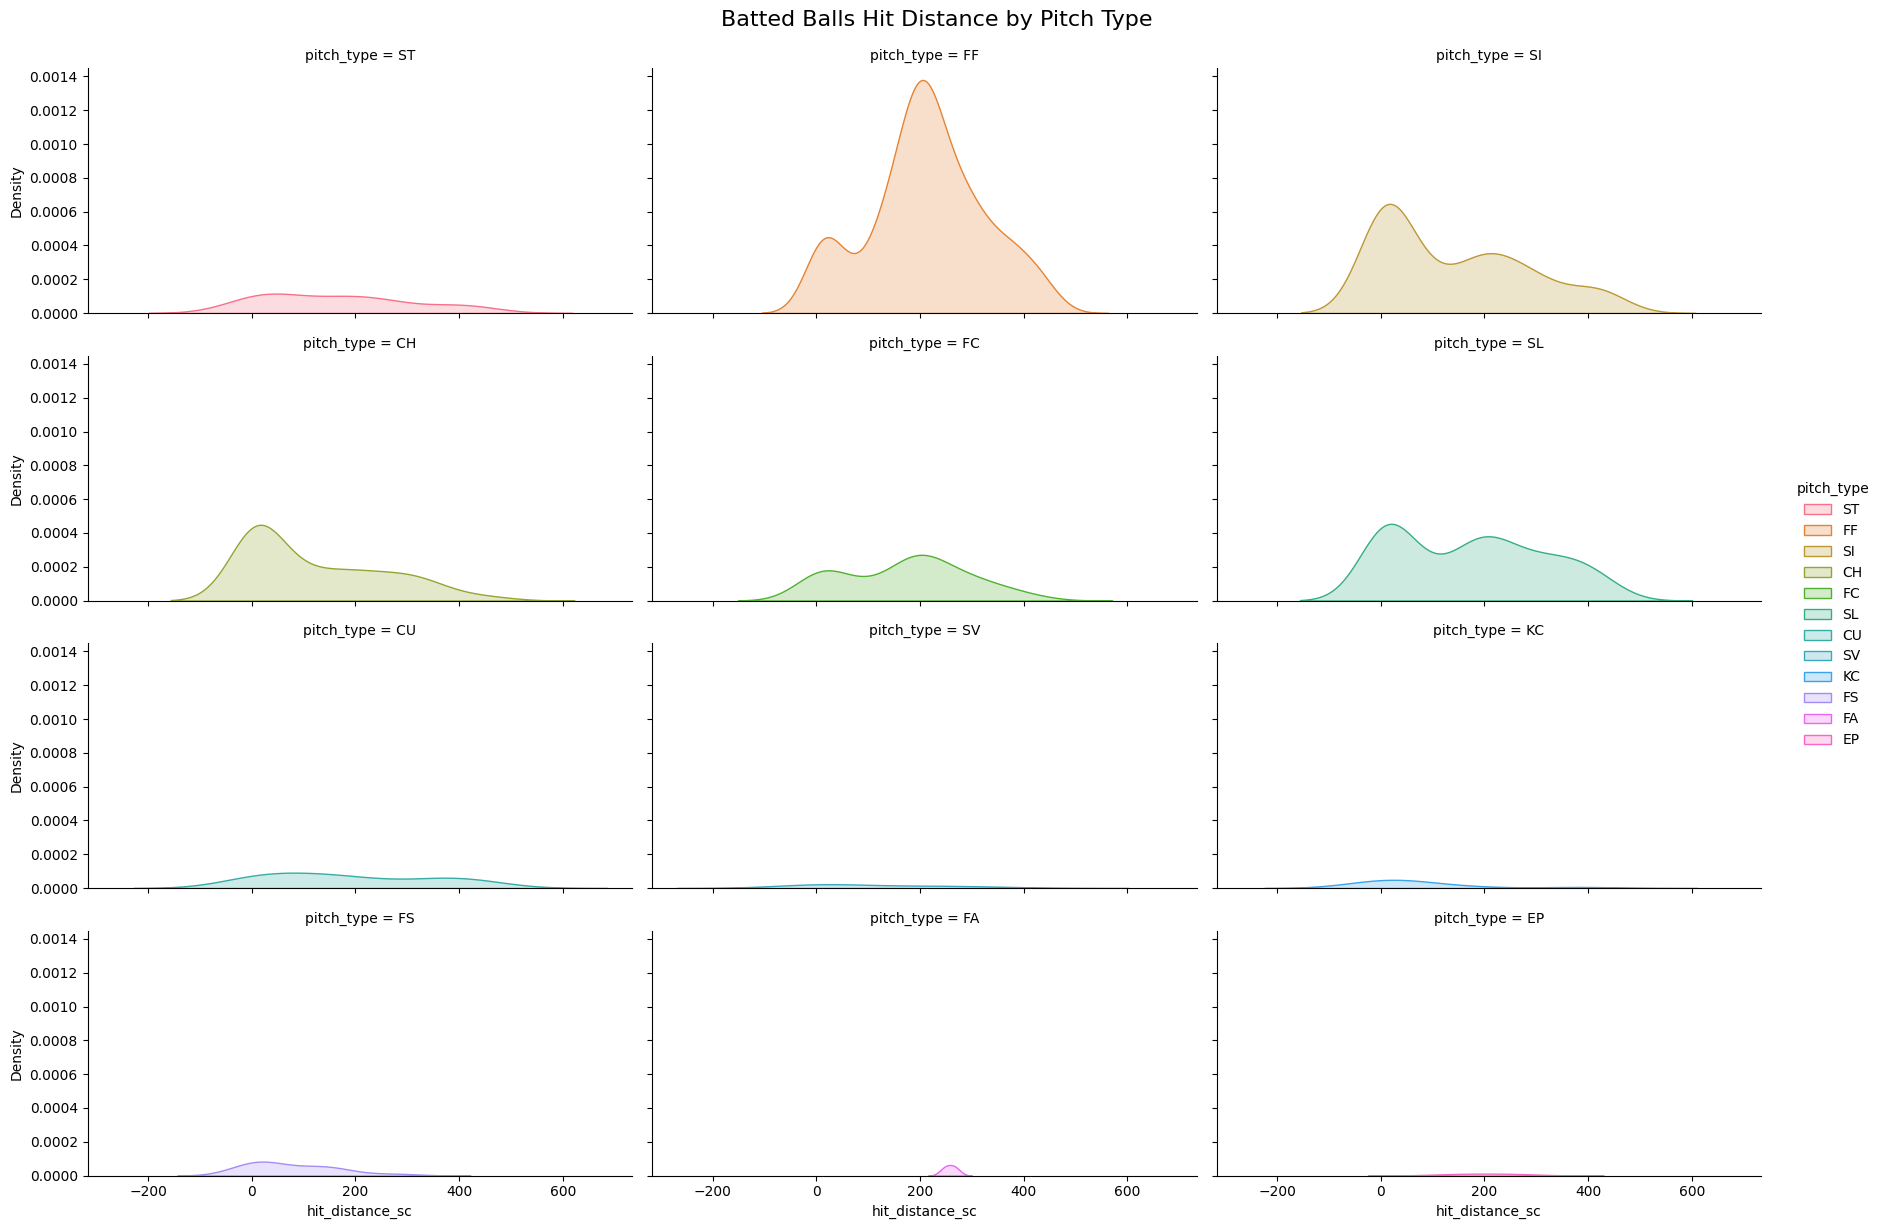

In [48]:
# displot of batted balls hit distance by pitch type for Judge
sns.displot(data=judge,x='hit_distance_sc',hue='pitch_type',kind='kde',col='pitch_type',col_wrap=3,fill=True,height=3,aspect=2)
plt.suptitle('Batted Balls Hit Distance by Pitch Type',ha='center',y=1.02,fontsize=16);

In [66]:
# look up Paul Goldschmidt player id
playerid_lookup('goldschmidt')

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,goldschmidt,paul,502671,goldp001,goldspa01,9218,2011.0,2023.0


In [51]:
# Goldschmidt statcast data
goldschmidt = statcast_batter('2022-04-07','2022-10-05',502671)
print('{} rows imported'.format(str(len(goldschmidt))))

Gathering Player Data
2701 rows imported


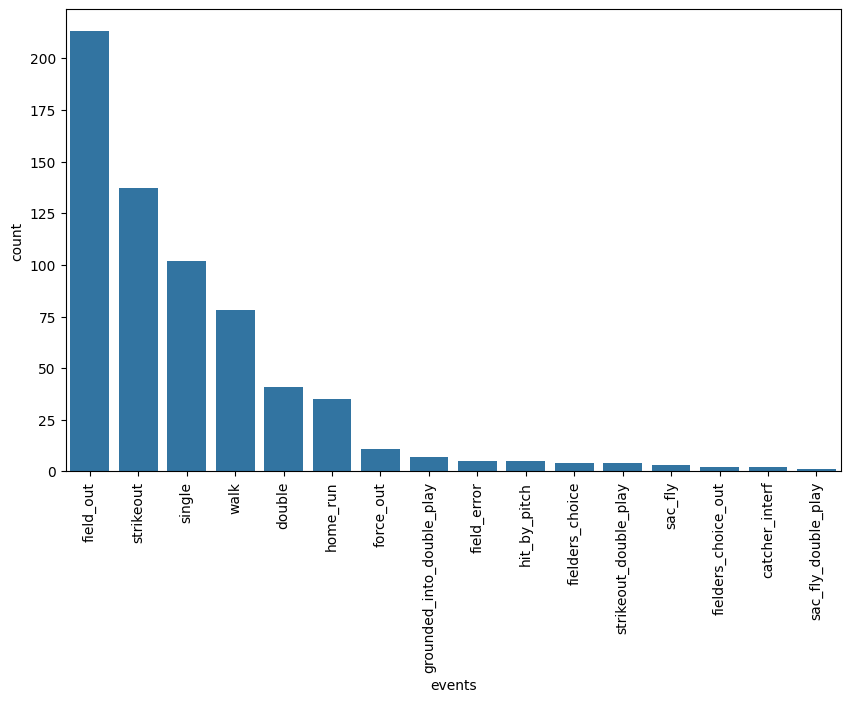

In [52]:
# countplot of the result of every Goldschmidt plate appearance
plt.figure(figsize=(10,6))
sns.countplot(data=goldschmidt,x='events',order=goldschmidt['events'].value_counts().index)
plt.xticks(rotation=90);

In [69]:
# percentages of every type of pitch thrown to Goldschmidt
goldschmidt['pitch_type'].value_counts(normalize=True)

pitch_type
FF    0.306553
SL    0.233247
SI    0.173639
CU    0.080341
FC    0.074417
CH    0.069234
ST    0.022214
KC    0.015550
FS    0.014809
SV    0.009996
Name: proportion, dtype: float64

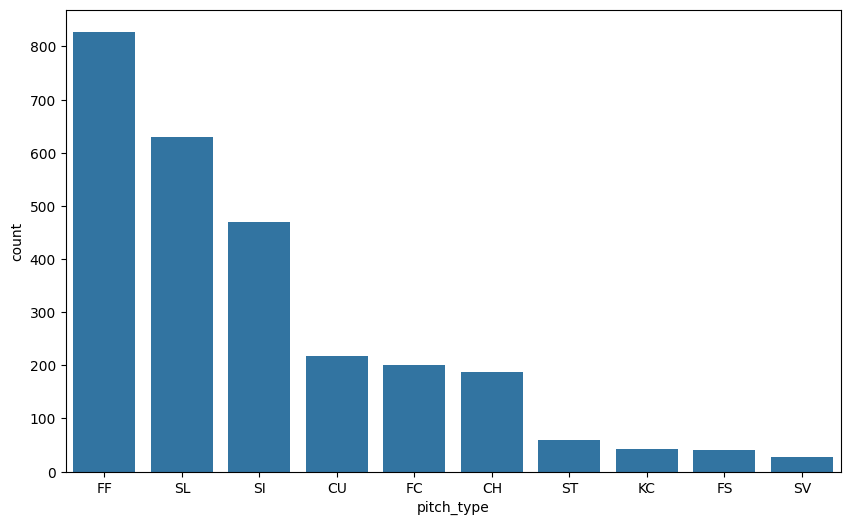

In [70]:
# countplot of every type of pitch thrown to Goldschmidt
plt.figure(figsize=(10,6))
sns.countplot(data=goldschmidt,x='pitch_type',order=goldschmidt['pitch_type'].value_counts().index);

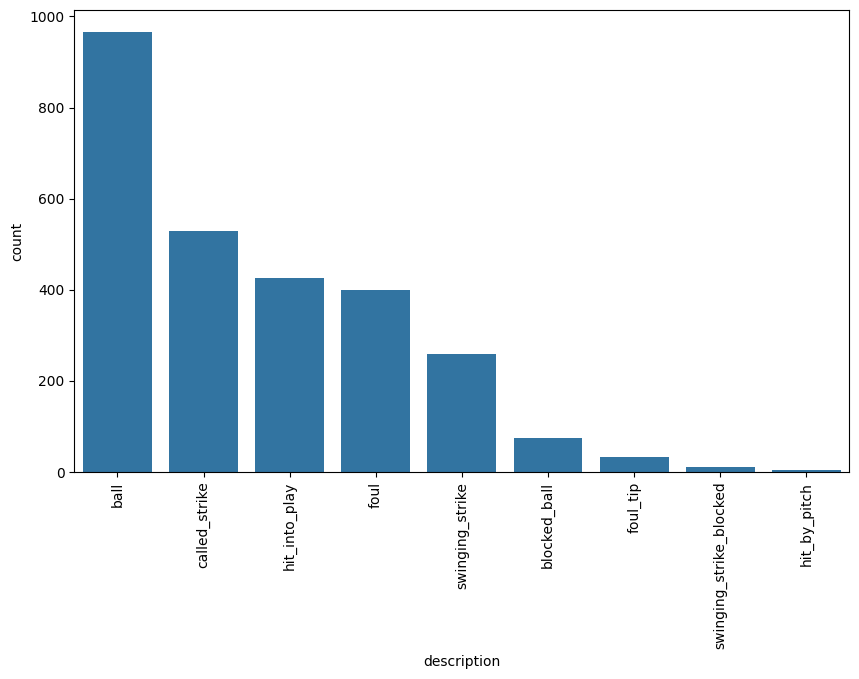

In [71]:
# countplot of the result of every pitch thrown to Goldschmidt
plt.figure(figsize=(10,6))
sns.countplot(data=goldschmidt,x='description',order=goldschmidt['description'].value_counts().index)
plt.xticks(rotation=90);

In [72]:
# percentages of the result of every batted ball by Goldschmidt
goldschmidt['bb_type'].value_counts(normalize=True)

bb_type
ground_ball    0.408019
fly_ball       0.287736
line_drive     0.228774
popup          0.075472
Name: proportion, dtype: float64

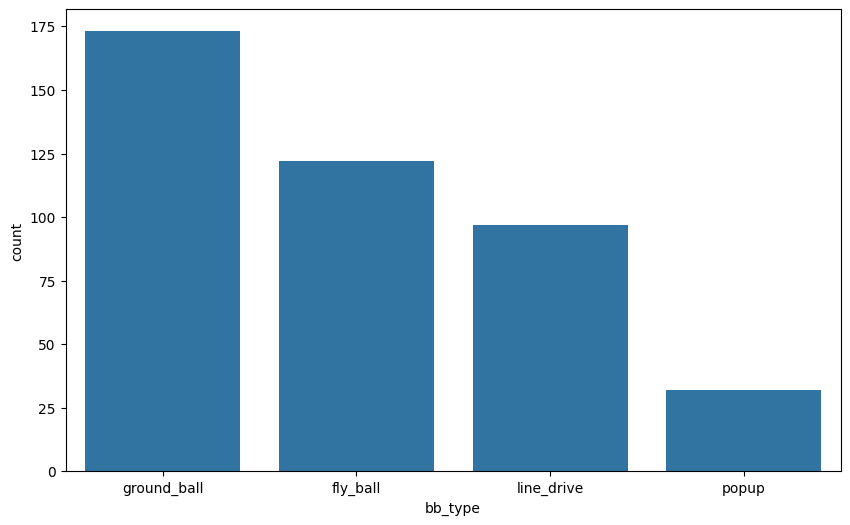

In [73]:
# countplot of the result of every batted ball by Goldschmidt
plt.figure(figsize=(10,6))
sns.countplot(data=goldschmidt,x='bb_type',order=goldschmidt['bb_type'].value_counts().index);

In [74]:
print('Average hit distance:',goldschmidt['hit_distance_sc'].mean())

Average hit distance: 169.2944942381562


In [75]:
print('Average launch angle:',goldschmidt['launch_angle'].mean())

Average launch angle: 18.224071702944943


In [76]:
print('Average exit velocity:',goldschmidt['launch_speed'].mean())

Average exit velocity: 85.0966709346991


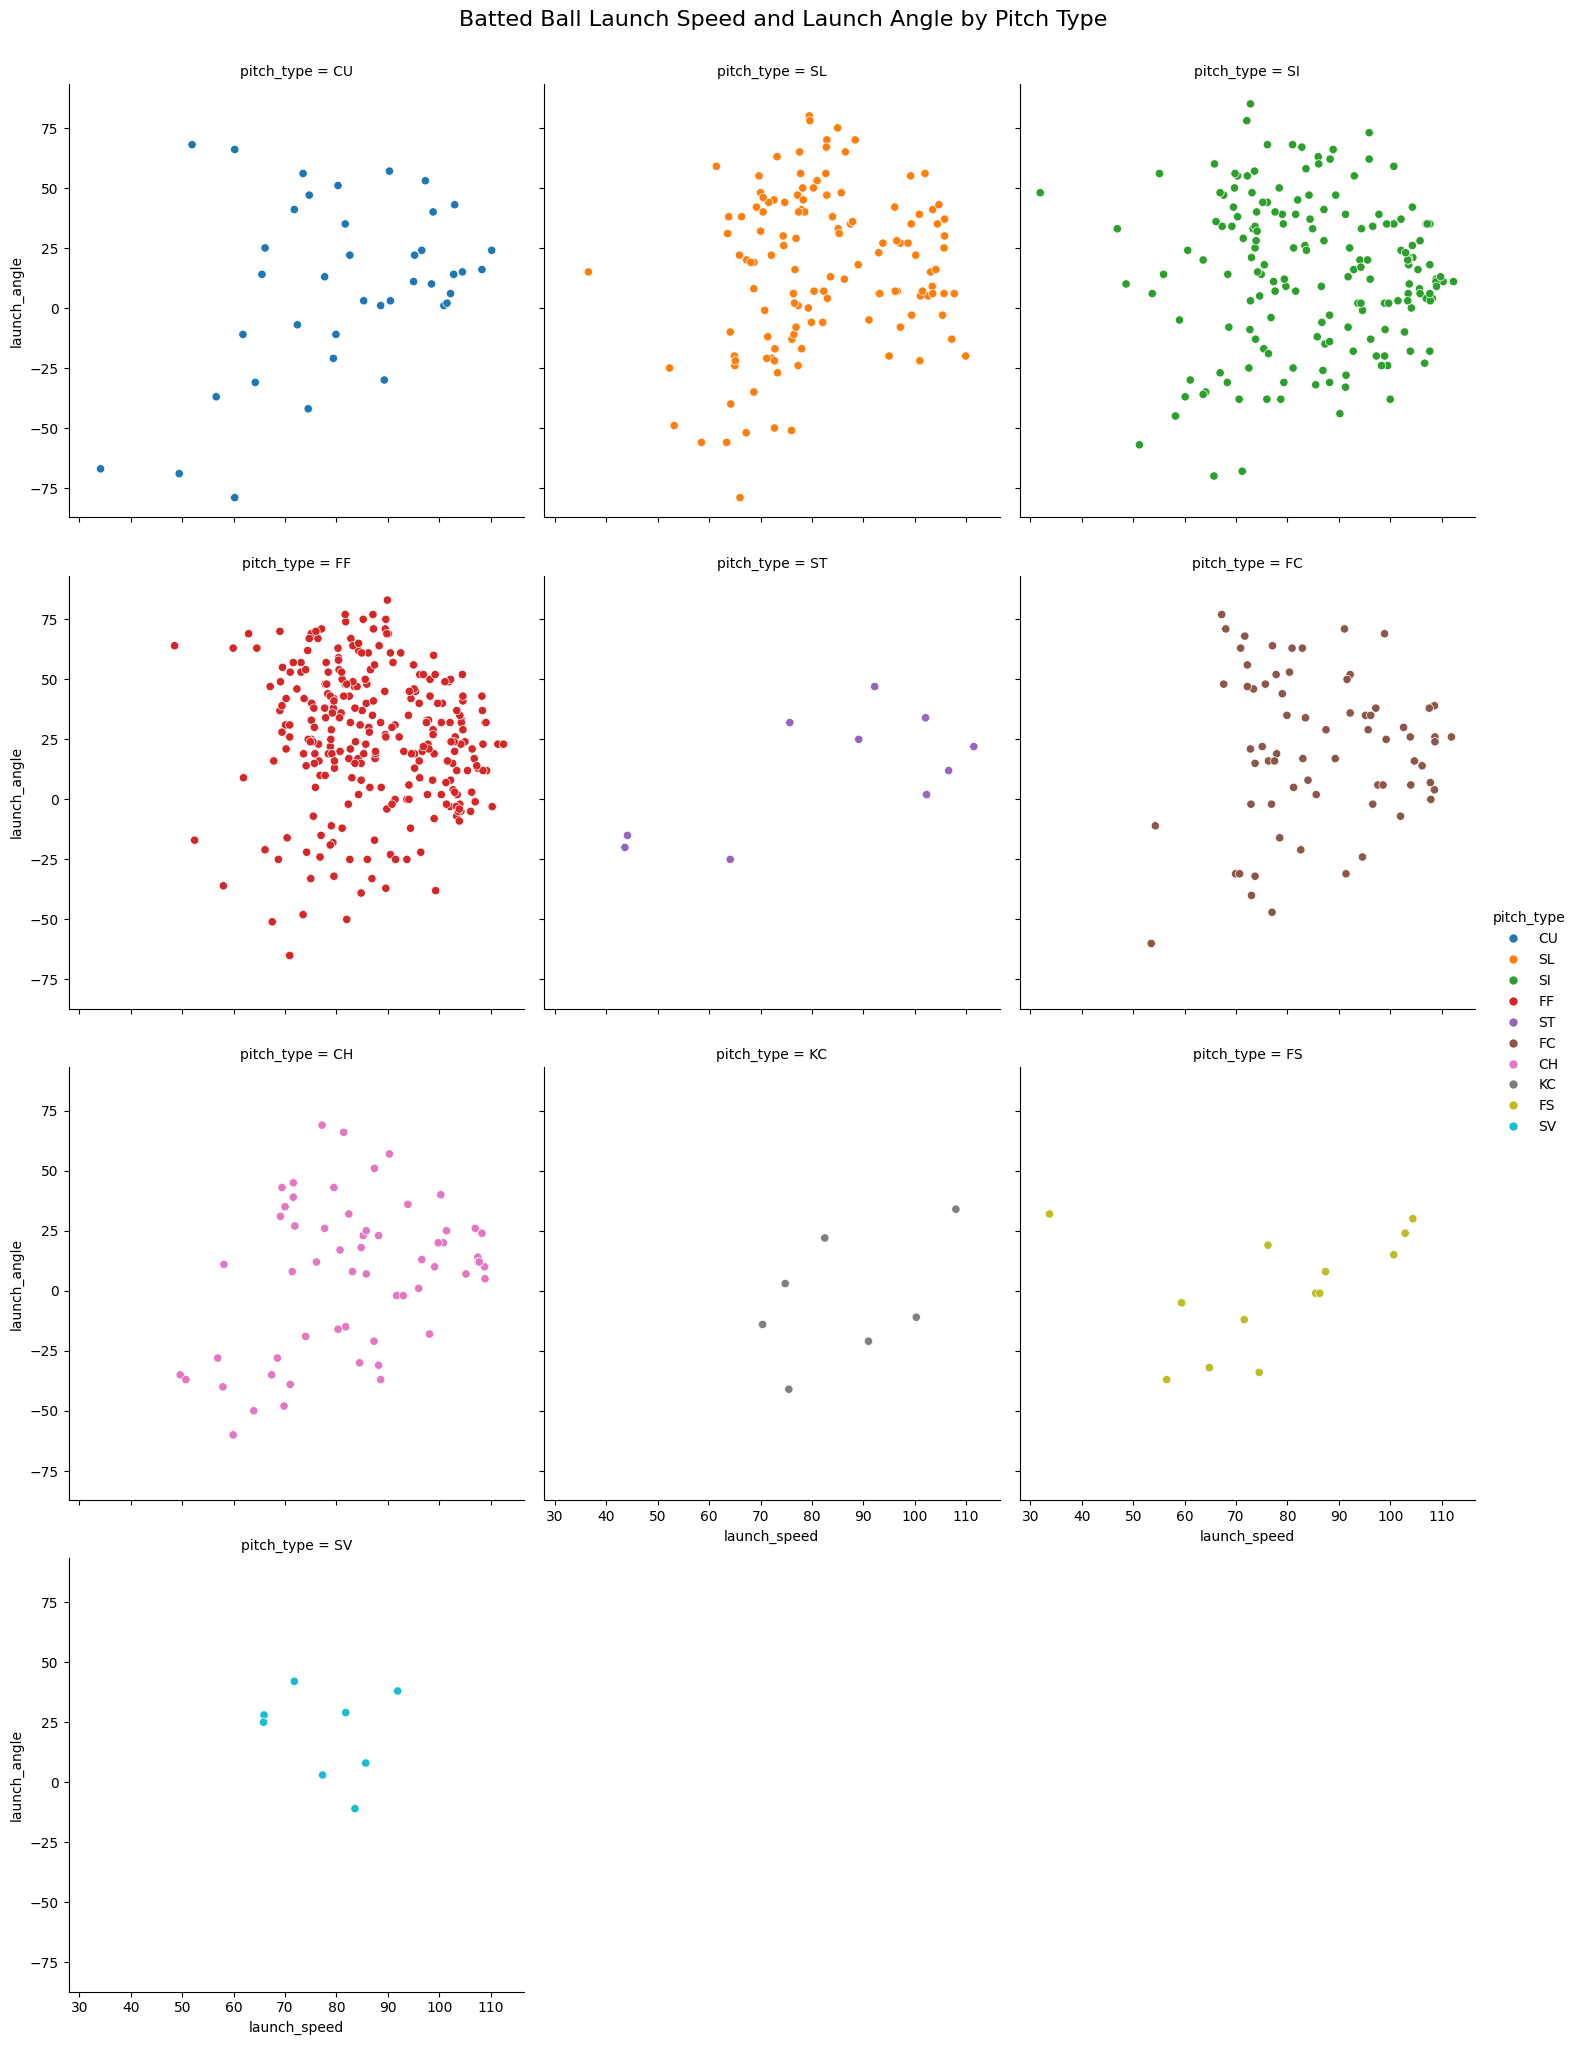

In [77]:
# relplot of batted ball launch speed and launch angle by pitch type for Goldschmidt
sns.relplot(data=goldschmidt,x='launch_speed',y='launch_angle',hue='pitch_type',col='pitch_type',col_wrap=3,height=5)
plt.suptitle('Batted Ball Launch Speed and Launch Angle by Pitch Type',ha='center',y=1.02,fontsize=16);

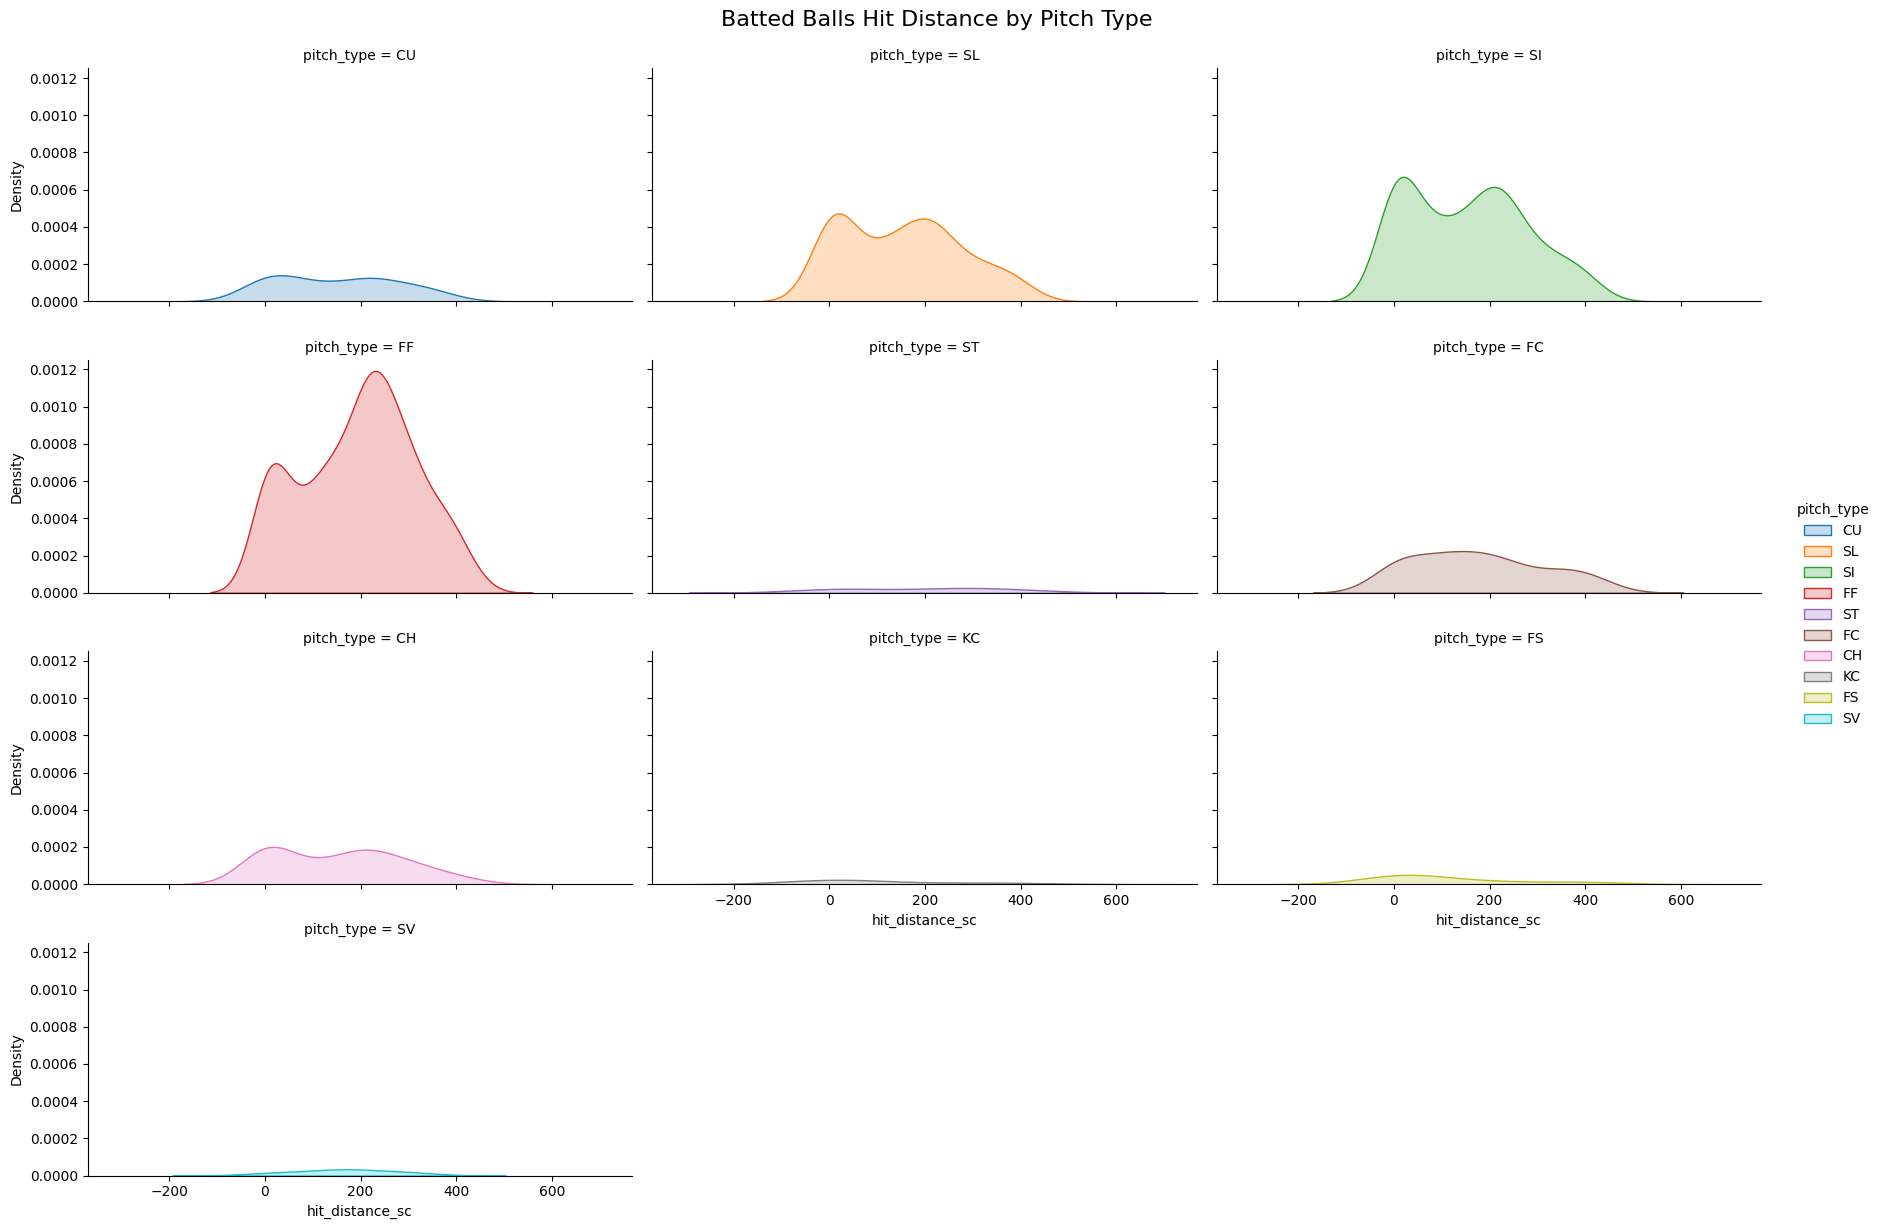

In [78]:
sns.displot(data=goldschmidt,x='hit_distance_sc',hue='pitch_type',kind='kde',col='pitch_type',col_wrap=3,fill=True,height=3,aspect=2)
plt.suptitle('Batted Balls Hit Distance by Pitch Type',ha='center',y=1.02,fontsize=16);

In [79]:
# look up Clayton Kershaw player id
playerid_lookup('kershaw')

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kershaw,clayton,477132,kersc001,kershcl01,2036,2008.0,2023.0


In [21]:
# kershaw statcast data
kershaw = statcast_pitcher('2022-04-07','2022-10-05',477132)
print('{} rows imported'.format(str(len(kershaw))))

Gathering Player Data
1842 rows imported


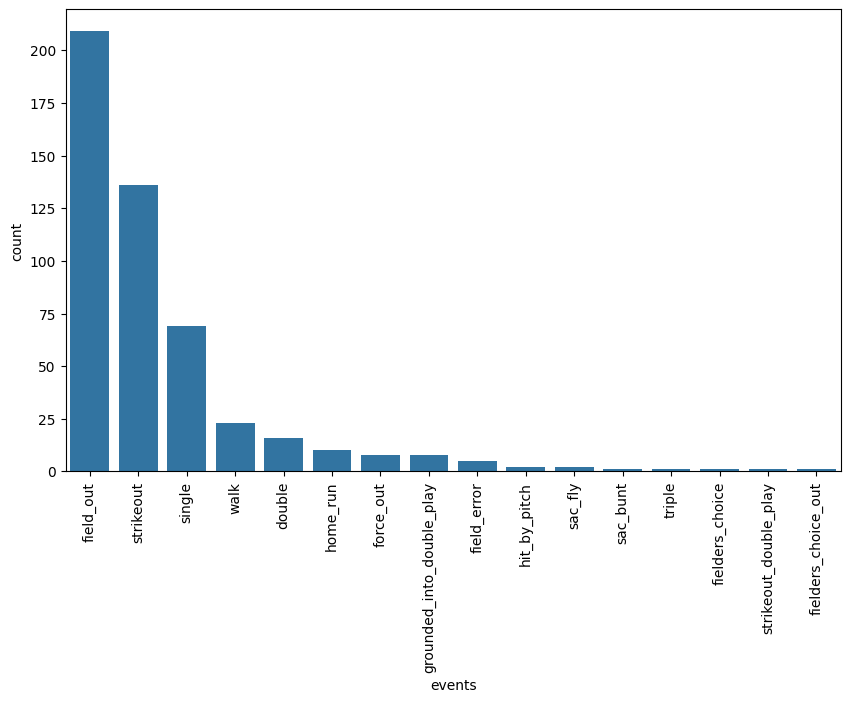

In [53]:
# countplot of the result of every plate appearance vs Kershaw
plt.figure(figsize=(10,6))
sns.countplot(data=kershaw,x='events',order=kershaw['events'].value_counts().index)
plt.xticks(rotation=90);

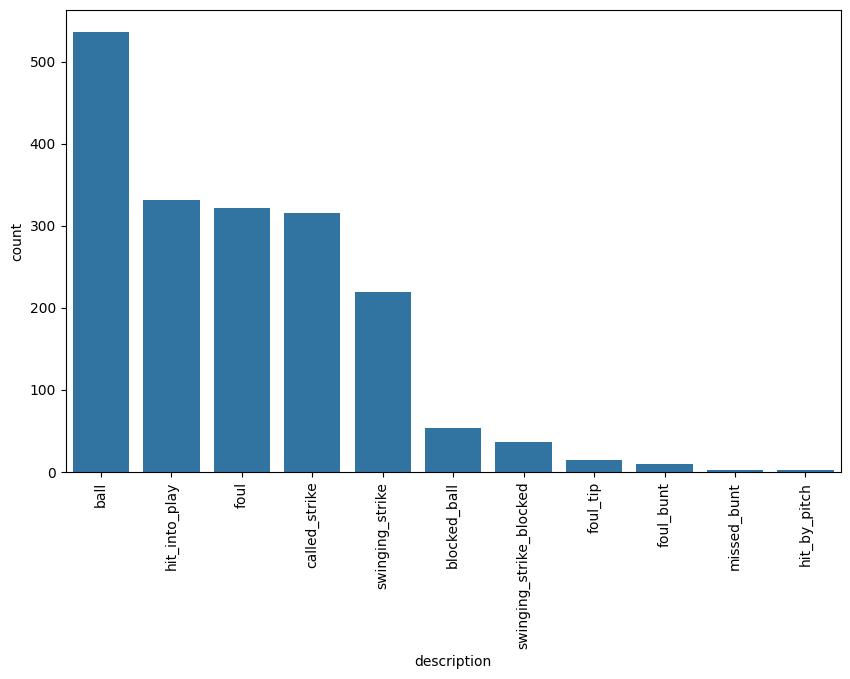

In [54]:
# countplot of the result of every pitch thrown by Kershaw
plt.figure(figsize=(10,6))
sns.countplot(data=kershaw,x='description',order=kershaw['description'].value_counts().index)
plt.xticks(rotation=90);

In [83]:
# percentages of the result of every batted ball from pitches thrown by Kershaw
kershaw['bb_type'].value_counts(normalize=True)

bb_type
ground_ball    0.477341
line_drive     0.223565
fly_ball       0.217523
popup          0.081571
Name: proportion, dtype: float64

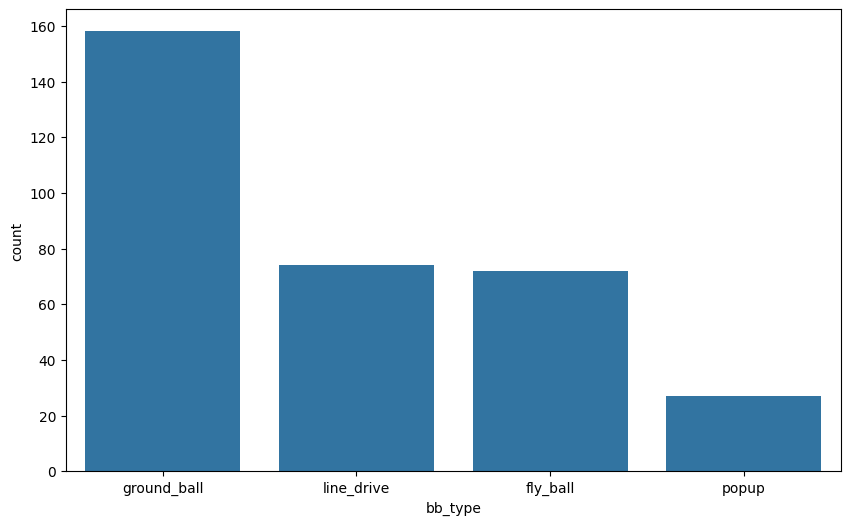

In [55]:
# countplot of the result of every batted ball from pitches thrown by Kershaw
plt.figure(figsize=(10,6))
sns.countplot(data=kershaw,x='bb_type',order=kershaw['bb_type'].value_counts().index);

In [85]:
# percentages of every pitch type thrown by Kershaw
kershaw['pitch_type'].value_counts(normalize=True)

pitch_type
SL    0.426710
FF    0.399566
CU    0.163409
CH    0.005972
SI    0.004343
Name: proportion, dtype: float64

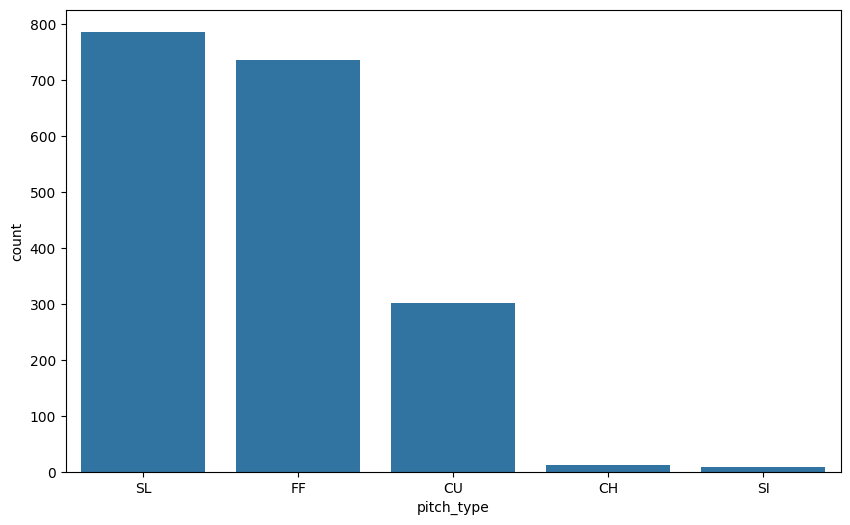

In [56]:
# countplot of every pitch type thrown by Kershaw
plt.figure(figsize=(10,6))
ax = sns.countplot(data=kershaw,x='pitch_type',order=kershaw['pitch_type'].value_counts().index);

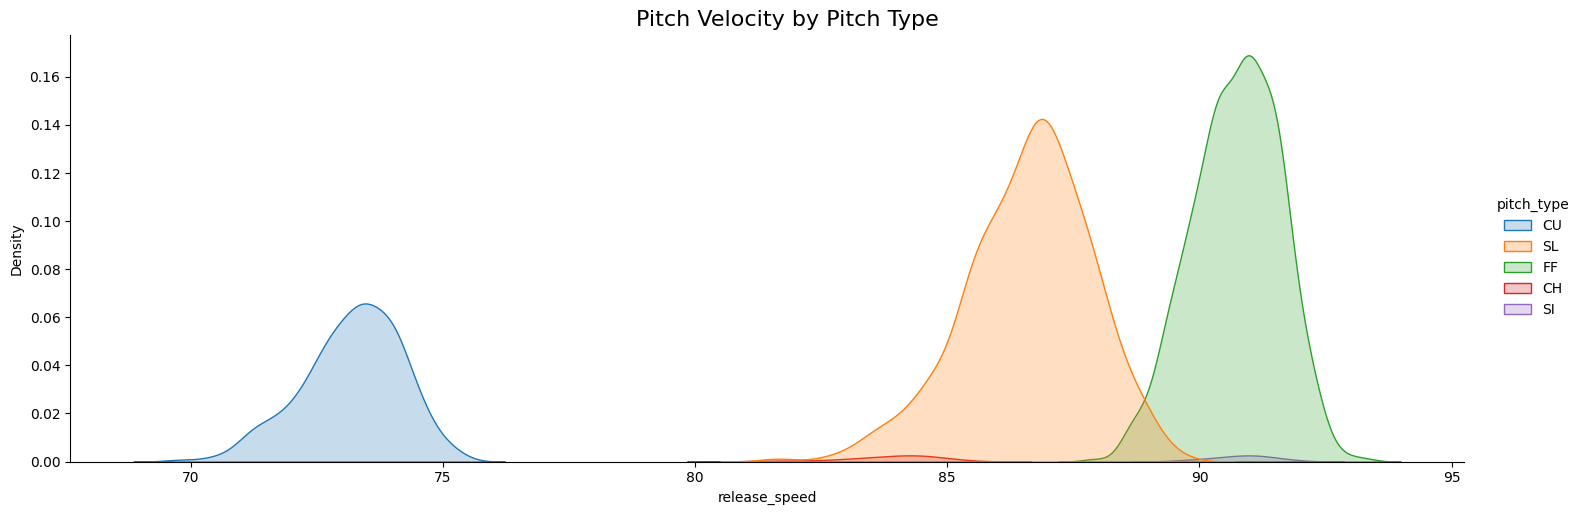

In [57]:
# displot of pitch velocity by pitch type
sns.displot(data=kershaw,x='release_speed',hue='pitch_type',kind='kde',fill=True,aspect=3)
plt.suptitle('Pitch Velocity by Pitch Type',ha='center',y=1.02,fontsize=16);

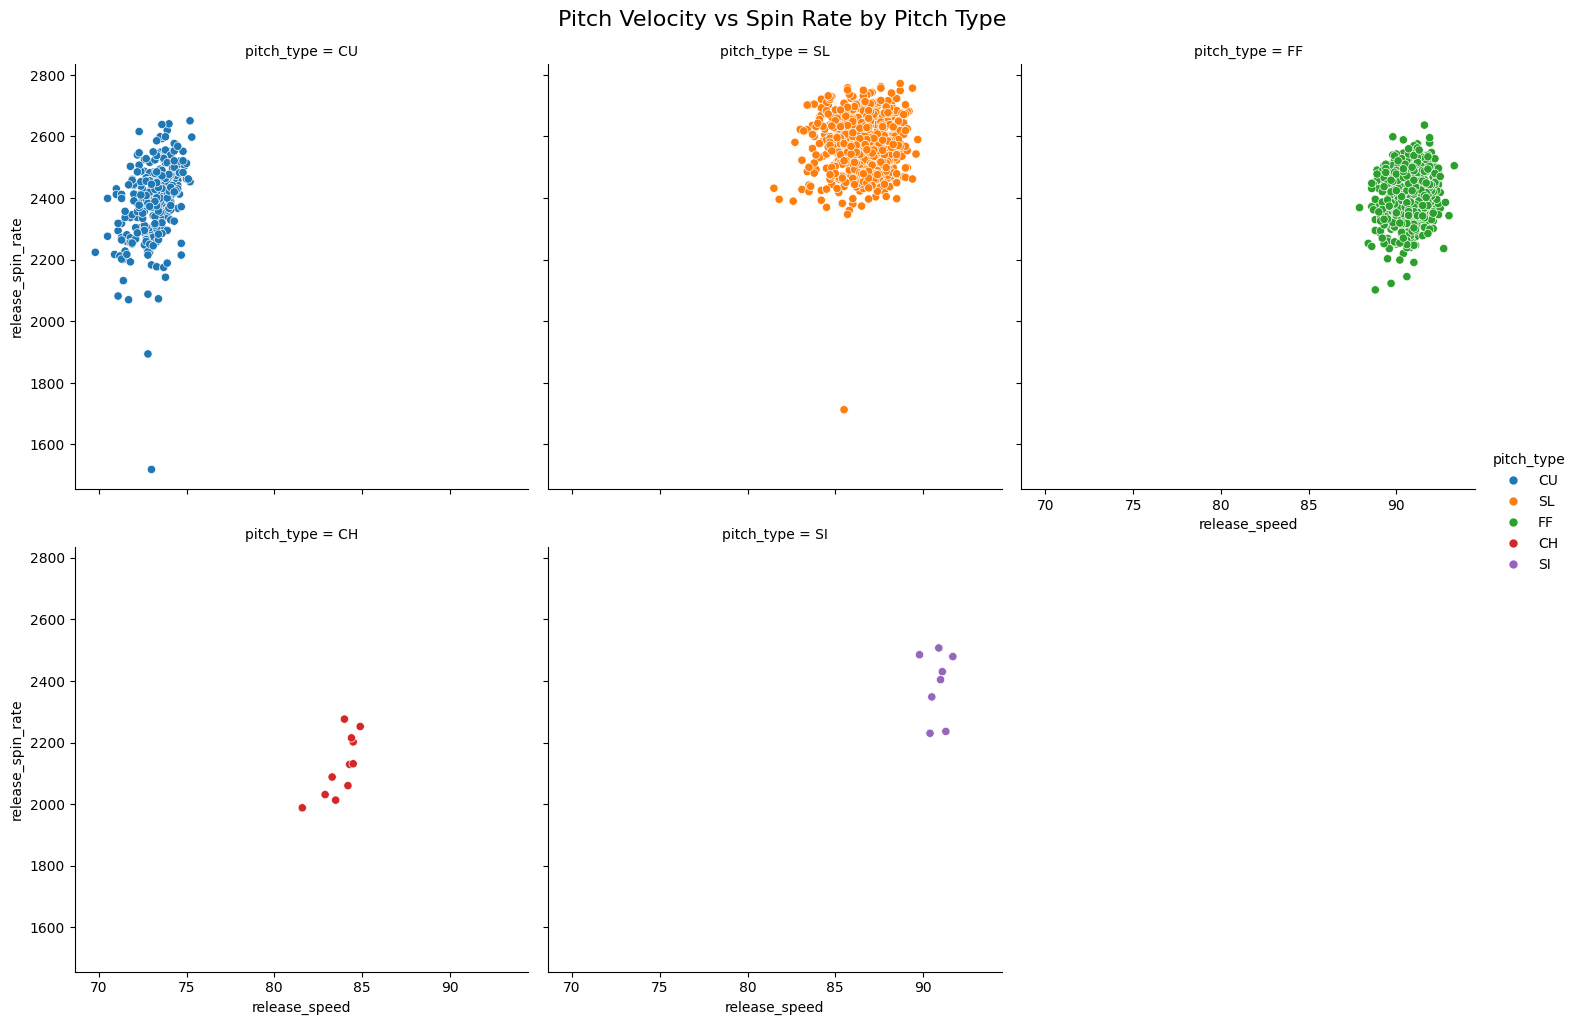

In [58]:
# pitch velocity vs spin rate by pitch type
sns.relplot(data=kershaw,x='release_speed',y='release_spin_rate',hue='pitch_type',col='pitch_type',col_wrap=3,height=5)
plt.suptitle('Pitch Velocity vs Spin Rate by Pitch Type',ha='center',y=1.02,fontsize=16);

plt.savefig('statcast_kershaw_6.png',bbox_inches='tight')

In [89]:
# look up Sandy Alcantara player id
playerid_lookup('alcantara')

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last


In [90]:
# Alcantara statcast data
alcantara = statcast_pitcher('2022-04-07','2022-10-05',645261)
print('{} rows imported'.format(str(len(alcantara))))

Gathering Player Data
3248 rows imported


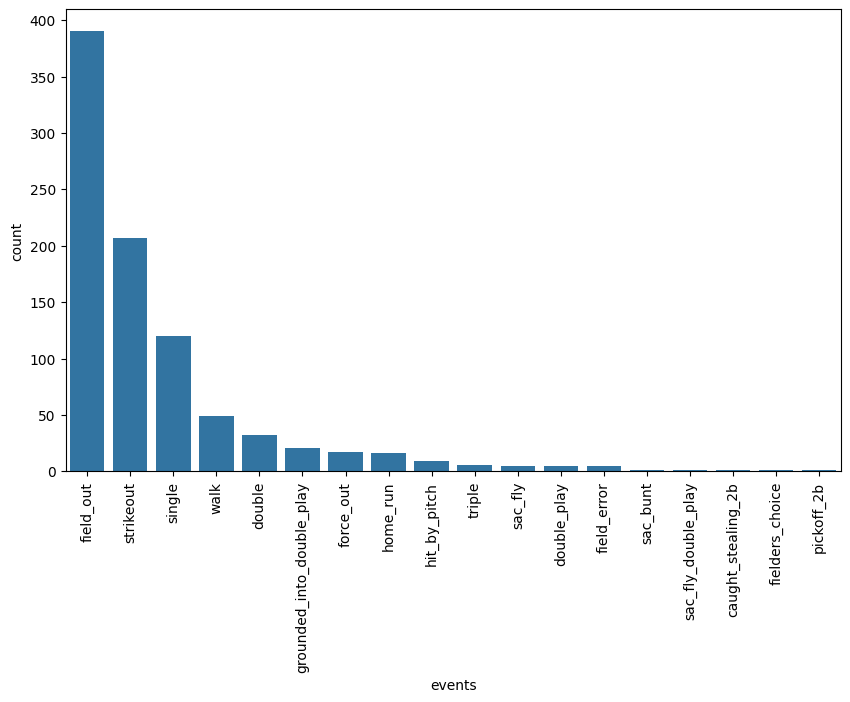

In [91]:
# countplot of the result of every plate appearance vs Alcantara
plt.figure(figsize=(10,6))
sns.countplot(data=alcantara,x='events',order=alcantara['events'].value_counts().index)
plt.xticks(rotation=90);

In [92]:
# percentages of the result of every batted ball from pitches thrown by Alcantara
alcantara['bb_type'].value_counts(normalize=True)

bb_type
ground_ball    0.541935
fly_ball       0.198387
line_drive     0.188710
popup          0.070968
Name: proportion, dtype: float64

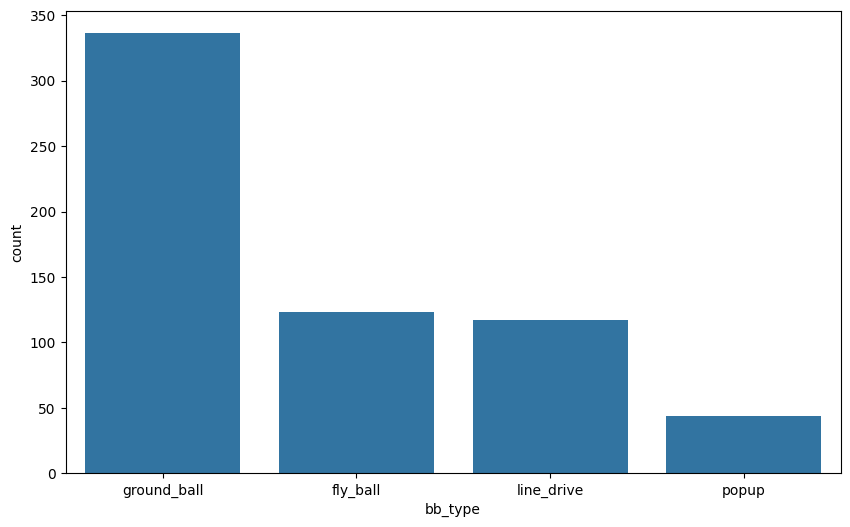

In [93]:
# countplot of the result of every batted ball from pitches thrown by Alcantara
plt.figure(figsize=(10,6))
sns.countplot(data=alcantara,x='bb_type',order=alcantara['bb_type'].value_counts().index);

In [94]:
# percentages of every pitch type thrown by Alcantara
alcantara['pitch_type'].value_counts(normalize=True)

pitch_type
CH    0.275554
FF    0.251232
SI    0.249692
SL    0.219828
CU    0.003387
PO    0.000308
Name: proportion, dtype: float64

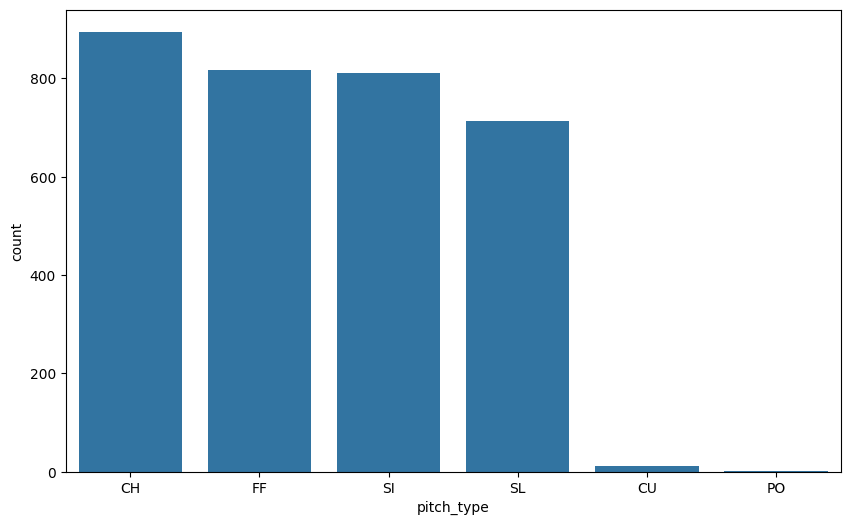

In [95]:
# countplot of every pitch type thrown by Alcantara
plt.figure(figsize=(10,6))
ax = sns.countplot(data=alcantara,x='pitch_type',order=alcantara['pitch_type'].value_counts().index);

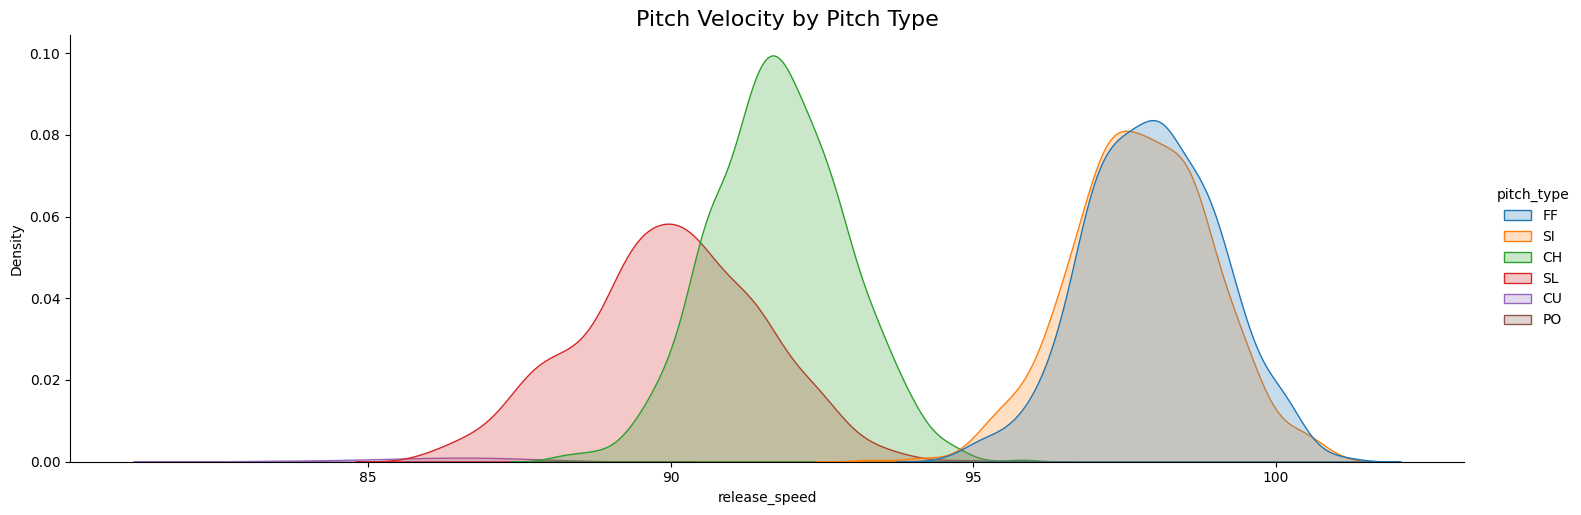

In [96]:
# displot of pitch velocity by pitch type
sns.displot(data=alcantara,x='release_speed',hue='pitch_type',kind='kde',fill=True,aspect=3)
plt.suptitle('Pitch Velocity by Pitch Type',ha='center',y=1.02,fontsize=16);

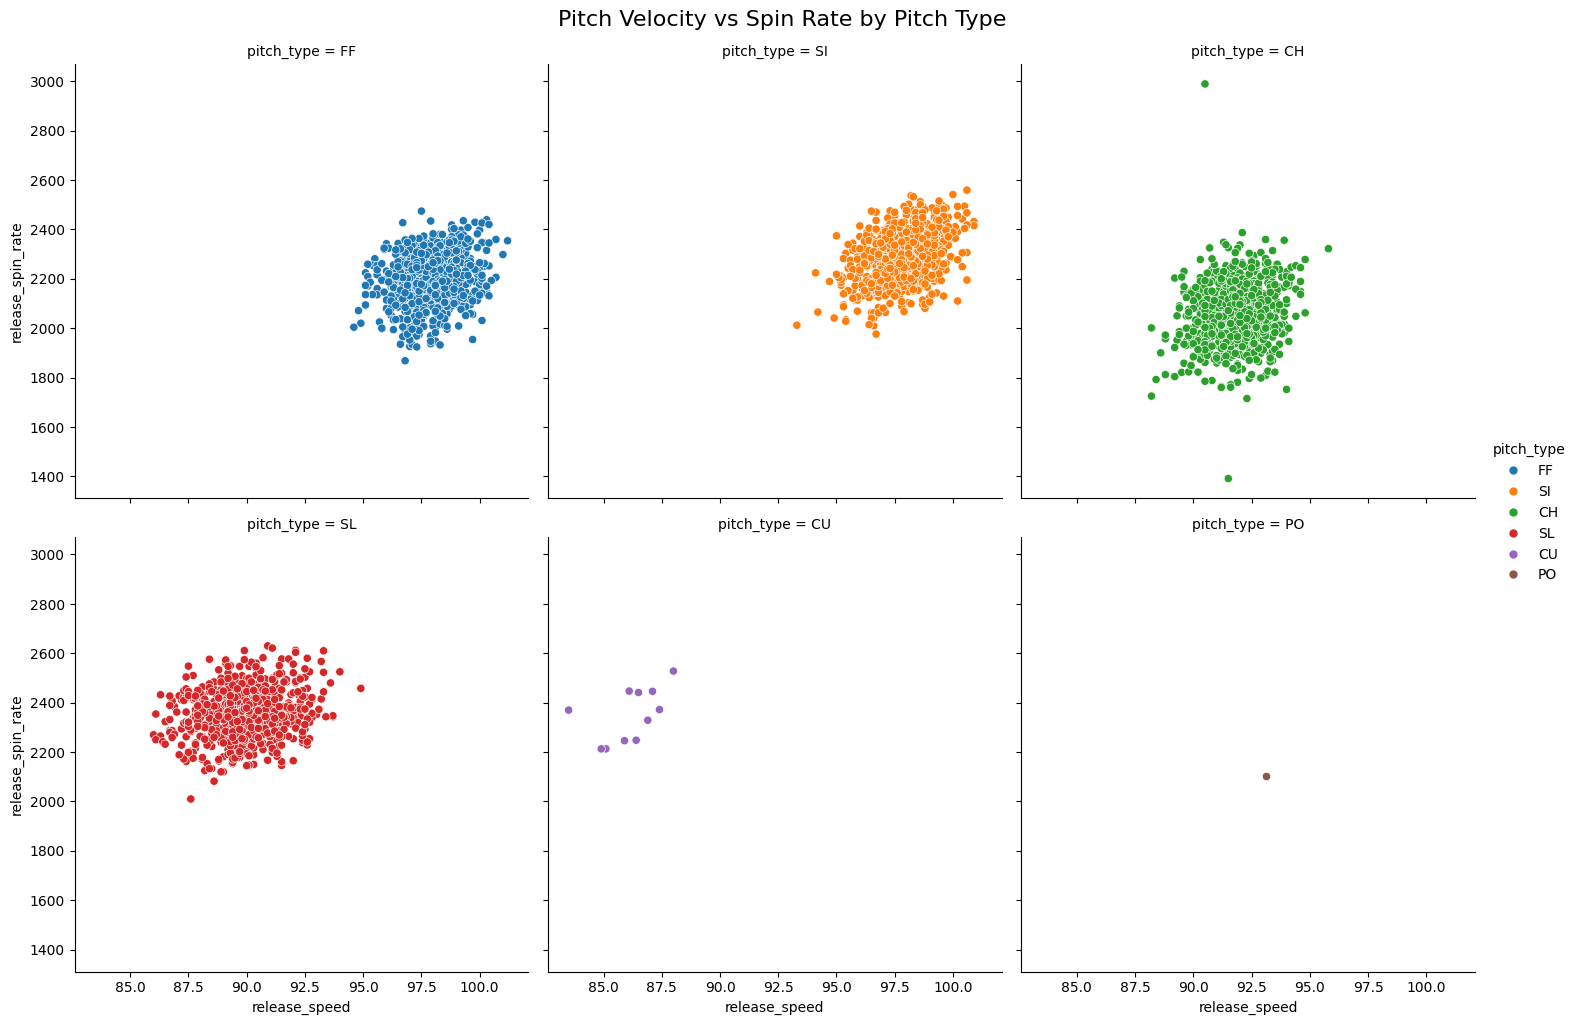

In [97]:
# pitch velocity vs spin rate by pitch type
sns.relplot(data=alcantara,x='release_speed',y='release_spin_rate',hue='pitch_type',col='pitch_type',col_wrap=3,height=5)
plt.suptitle('Pitch Velocity vs Spin Rate by Pitch Type',ha='center',y=1.02,fontsize=16);

### Salary Data

In [28]:
# new dataframes for salaries, players, teams, and home games
salaries = lahman.salaries()
names = lahman.people()
teams = lahman.teams_core()
home_games = lahman.home_games()

In [99]:
# salaries
salaries.sample(5)

,yearID,teamID,lgID,playerID,salary
5838,1993,CLE,AL,chrismi02,123000
4,1985,ATL,NL,ceronri01,625000
19827,2009,ARI,NL,reynoma01,422500
24190,2014,COL,NL,morneju01,5000000
3111,1989,PIT,NL,landrbi01,75000


In [100]:
# names
names.sample(5)

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
3746,corbipa01,1989.0,7.0,19.0,USA,NY,Clay,NaN,NaN,NaN,...,Corbin,Patrick Alan,222.0,76.0,L,L,2012-04-30,2022-10-02,corbp001,corbipa01
11326,mahompa01,1970.0,8.0,9.0,USA,TX,Bryan,NaN,NaN,NaN,...,Mahomes,Patrick Lavon,175.0,73.0,R,R,1992-04-12,2003-08-26,mahop001,mahompa01
20187,windejo01,1996.0,10.0,11.0,USA,VA,Richmond,NaN,NaN,NaN,...,Winder,Joshua Stewart,210.0,77.0,R,R,2022-04-12,2022-10-04,windj002,windejo01
15337,reedebi01,1922.0,2.0,20.0,USA,TX,Dike,2001.0,3.0,12.0,...,Reeder,William Edgar,205.0,77.0,R,R,1949-04-23,1949-09-22,reedb101,reedebi01
13739,oconnfr01,1868.0,9.0,15.0,USA,NY,Keeseville,1913.0,12.0,26.0,...,O'Connor,Francis Henry,185.0,72.0,L,L,1893-08-03,1893-08-07,oconf101,o'confr01


In [101]:
# teams
teams.sample(5)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
1325,1958,NL,SLN,STL,NaN,5,154,77.0,72,82,...,163,0.975,St. Louis Cardinals,Sportsman's Park IV,1063730.0,104,105,STL,SLN,SLN
344,1897,NL,CL4,CLV,NaN,5,130,NaN,69,62,...,74,0.950,Cleveland Spiders,League Park I,115250.0,110,109,CLV,CL4,CL4
1313,1958,AL,CHA,CHW,NaN,2,155,77.0,82,72,...,160,0.981,Chicago White Sox,Comiskey Park,797451.0,99,97,CHW,CHA,CHA
667,1917,NL,PIT,PIT,NaN,8,157,79.0,51,103,...,119,0.961,Pittsburgh Pirates,Forbes Field,192807.0,103,105,PIT,PIT,PIT
1907,1984,NL,NYN,NYM,E,2,162,81.0,90,72,...,154,0.979,New York Mets,Shea Stadium,1842695.0,99,99,NYM,NYN,NYN


In [102]:
# home_games
home_games.sample(5)

,year.key,league.key,team.key,park.key,span.first,span.last,games,openings,attendance
2846,2011,NL,SFN,SFO03,2011-04-08,2011-09-28,81,81,3387303
2392,1997,AL,CLE,CLE08,1997-04-11,1997-09-28,81,80,3394750
2695,2007,NL,ARI,PHO01,2007-04-09,2007-09-23,81,81,2316507
3146,2020,AL,SEA,SEA03,2020-07-31,2020-09-23,24,0,0
314,1890,NL,CL4,IND06,1890-07-28,1890-08-02,6,0,0


In [29]:
# group team salaries into years
salaries_years = salaries.groupby('yearID',as_index=False)['salary'].sum()
salaries_years.tail(10)

,yearID,salary
22,2007,2476688987
23,2008,2684858670
24,2009,2664726994
25,2010,2721359865
26,2011,2784505291
27,2012,2932741192
28,2013,3034525648
29,2014,3192317623
30,2015,3514142569
31,2016,3750137392


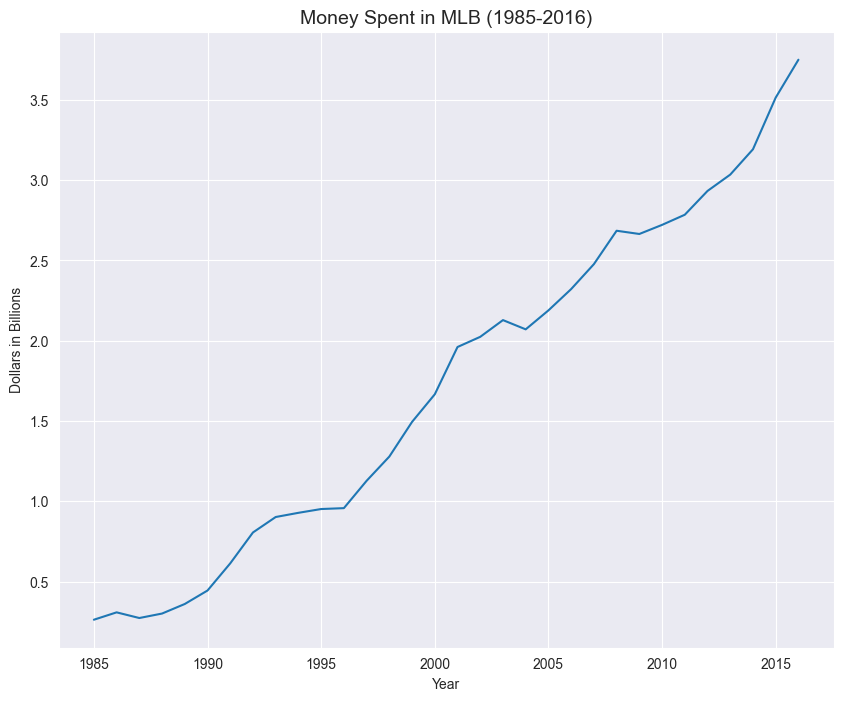

In [121]:
# plot of money spent in MLB from 1985-2016
sns.set_style('darkgrid')
year_id = salaries_years['yearID']
salary = salaries_years['salary'] / 1e9

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(year_id,salary)
ax.set_xlabel('Year')
ax.set_ylabel('Dollars in Billions')
ax.set_title('Money Spent in MLB (1985-2016)',fontsize=14);

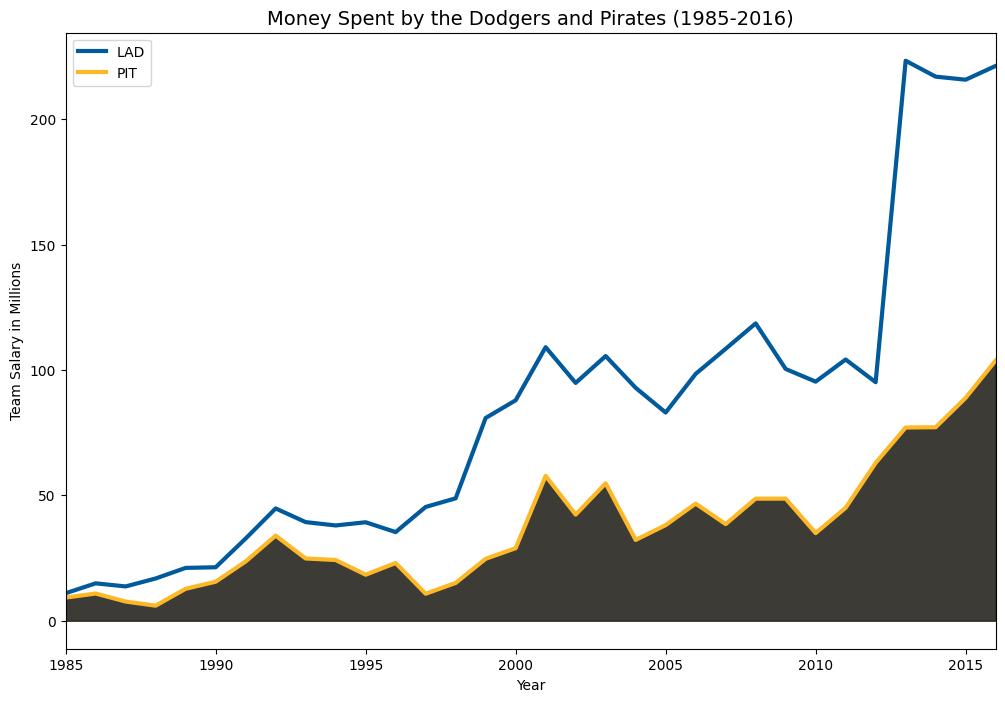

In [32]:
# comparison plot of money spent by the Dodgers and the Pirates from 1985-2016
salaries_teams_years = salaries.groupby(['teamID','yearID'],as_index=False)['salary'].sum()
lad = salaries_teams_years.loc[salaries_teams_years['teamID']=='LAN']
pit = salaries_teams_years.loc[salaries_teams_years['teamID']=='PIT']

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(lad['yearID'],lad['salary']/1000000,label='LAD',color='#005A9C',lw=3)
ax.plot(pit['yearID'],pit['salary']/1000000,label='PIT',color='#FDB827',lw=3)

line_1 = ax.get_lines()[0].get_xydata()
line_2 = ax.get_lines()[1].get_xydata()

x_1, y_1 = line_1[:,0], line_1[:,1]
x_2, y_2 = line_2[:,0], line_2[:,1]
ax.fill_between(x_1,y_1,color='#FFFFFF',alpha=0.9)
ax.fill_between(x_2,y_2,color='#27251F',alpha=0.9)

ax.set_xlabel('Year')
ax.set_ylabel('Team Salary in Millions')
ax.set_title('Money Spent by the Dodgers and Pirates (1985-2016)',fontsize=14)
ax.set_xlim([1985,2016])
ax.legend(loc='upper left');

In [138]:
# Pirates top 5 years of salary
pit.sort_values(by='salary',ascending=False).head()

,teamID,yearID,salary
694,PIT,2016,103778833
693,PIT,2015,88892499
692,PIT,2014,77178000
691,PIT,2013,77062000
690,PIT,2012,62951999


In [139]:
# Dodgers top 5 years of salary
lad.sort_values(by='salary',ascending=False).head()

,teamID,yearID,salary
442,LAN,2013,223362196
445,LAN,2016,221288380
443,LAN,2014,217014600
444,LAN,2015,215792000
437,LAN,2008,118588536


In [140]:
# top 10 team salaries
salaries_teams_years.sort_values(by='salary',ascending=False).head(10)

,teamID,yearID,salary
563,NYA,2013,231978886
442,LAN,2013,223362196
566,NYA,2016,222997792
445,LAN,2016,221288380
443,LAN,2014,217014600
444,LAN,2015,215792000
565,NYA,2015,212751957
555,NYA,2005,208306817
558,NYA,2008,207896789
560,NYA,2010,206333389


In [33]:
# merge salaries and teams df and new columns salary per win and salary per attendance
money_wins = salaries_teams_years.merge(teams,on=['teamID','yearID'])

lad_pit = money_wins[(money_wins['teamID']=='LAN') | (money_wins['teamID']=='PIT')]
lad_pit['salary/win'] = lad_pit['salary'] / lad_pit['W']
lad_pit['salary/attend'] = lad_pit['salary'] / lad_pit['attendance']

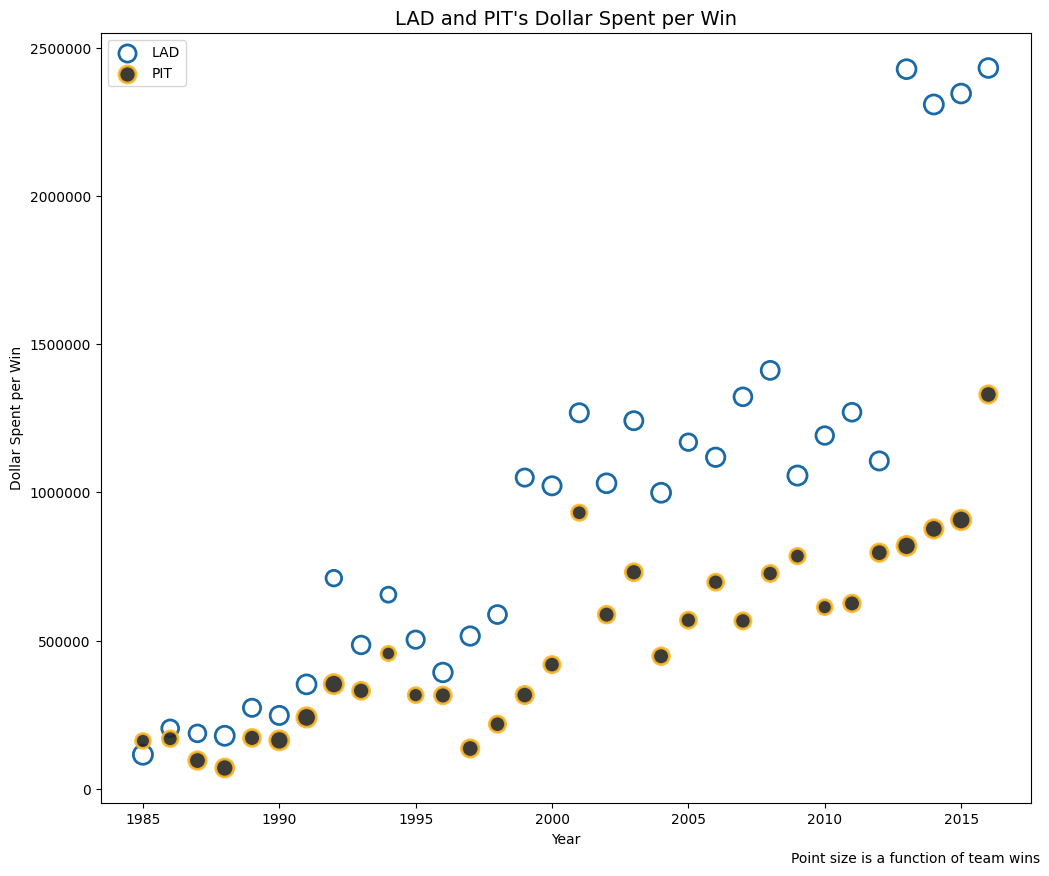

In [59]:
# plot of Dodgers and Pirates dollar spent per win
lad = lad_pit.loc[lad_pit['teamID']=='LAN']
pit = lad_pit.loc[lad_pit['teamID']=='PIT']

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(x='yearID',y='salary/win',data=lad,color='#FFFFFF',alpha=0.9,edgecolors='#005A9C',lw=2,s=lad['W']*2)
ax.scatter(x='yearID',y='salary/win',data=pit,color='#27251F',alpha=0.9,edgecolors='#FDB827',lw=2,s=pit['W']*2)

ax.ticklabel_format(style='plain',useOffset=False)
ax.set_xlabel('Year')
ax.set_ylabel('Dollar Spent per Win')
ax.set_title('LAD and PIT\'s Dollar Spent per Win',fontsize=14)
ax.legend(['LAD','PIT'],loc='upper left')
fig.text(0.7,0.05,'Point size is a function of team wins');

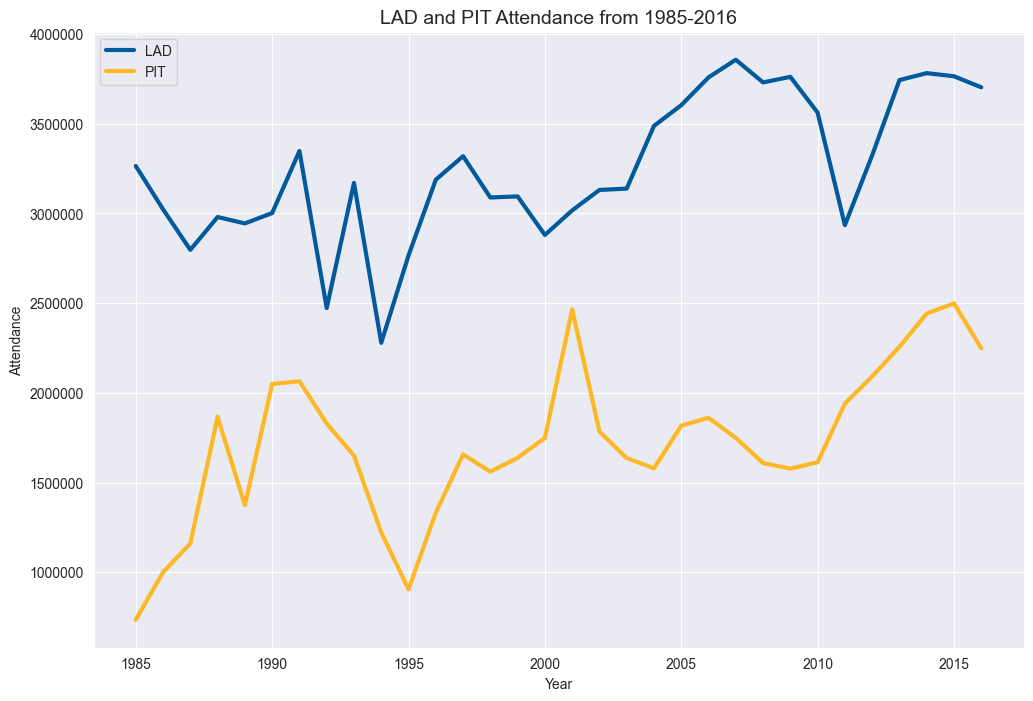

In [144]:
# plot of Dodgers and Pirates attendance 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(lad['yearID'],lad['attendance'],color='#005A9C',lw=3)
ax.plot(pit['yearID'],pit['attendance'],color='#FDB827',lw=3)

ax.ticklabel_format(style='plain',useOffset=False)
ax.set_xlabel('Year')
ax.set_ylabel('Attendance')
ax.set_title('LAD and PIT Attendance from 1985-2016',fontsize=14)
ax.legend(['LAD','PIT'],loc='upper left');

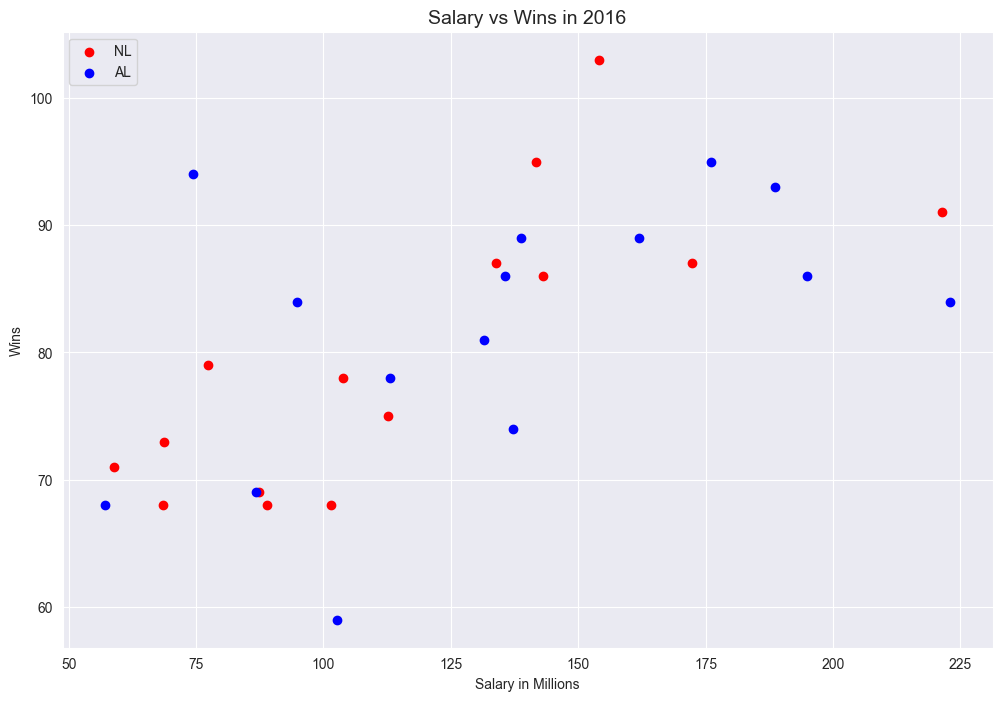

In [146]:
# MLB team salart vs wins in 2016
money_wins_2016 = money_wins.loc[money_wins['yearID']==2016]
money_wins_nl  = money_wins_2016.loc[money_wins_2016['lgID']=='NL']
money_wins_al  = money_wins_2016.loc[money_wins_2016['lgID']=='AL']

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(money_wins_nl['salary']/1000000,money_wins_nl['W'],color='red',label='NL')
ax.scatter(money_wins_al['salary']/1000000,money_wins_al['W'],color='blue',label='AL')

ax.set_xlabel('Salary in Millions')
ax.set_ylabel('Wins')
ax.set_title('Salary vs Wins in 2016',fontsize=14)
ax.legend(loc='upper left');

### Machine Learning Models

**Linear Regression**

In [149]:
# batting dataframes
batting_df = batting_stats(2010,2022,qual=10)
bat_2022_df = batting_stats(2021,2022,qual=10)

In [152]:
# Mike Trout dataframe
hits_df = batting_df.loc[:,['Season','Name','AB','H','OPS','BABIP','wOBA','wRC+','LD%','GB%','FB%','O-Swing%','Z-Swing%','O-Contact%','Z-Contact%',
                            'SwStr%','Contact%','Swing%','Pull%','Cent%','Oppo%','Soft%','Med%','Hard%']]
hits_df['wRC+_next_season'] = hits_df.sort_values(['Name','Season'],ascending=False).groupby('Name')['wRC+'].shift()
hits_df = hits_df.loc[hits_df['AB']>=300]
hits_df = hits_df.loc[hits_df['wRC+_next_season'].notnull()]
hits_df.loc[hits_df['Name']=='Mike Trout',['Name','Season','AB','OPS','wOBA','wRC+','wRC+_next_season']].sort_values(by='Season')

,Name,Season,AB,OPS,wOBA,wRC+,wRC+_next_season
163,Mike Trout,2012,559,0.963,0.409,167,176.0
94,Mike Trout,2013,589,0.988,0.423,176,167.0
203,Mike Trout,2014,602,0.939,0.402,167,171.0
129,Mike Trout,2015,575,0.991,0.415,171,170.0
113,Mike Trout,2016,549,0.991,0.418,170,180.0
66,Mike Trout,2017,402,1.071,0.437,180,188.0
45,Mike Trout,2018,471,1.088,0.447,188,177.0
69,Mike Trout,2019,470,1.083,0.436,177,160.0


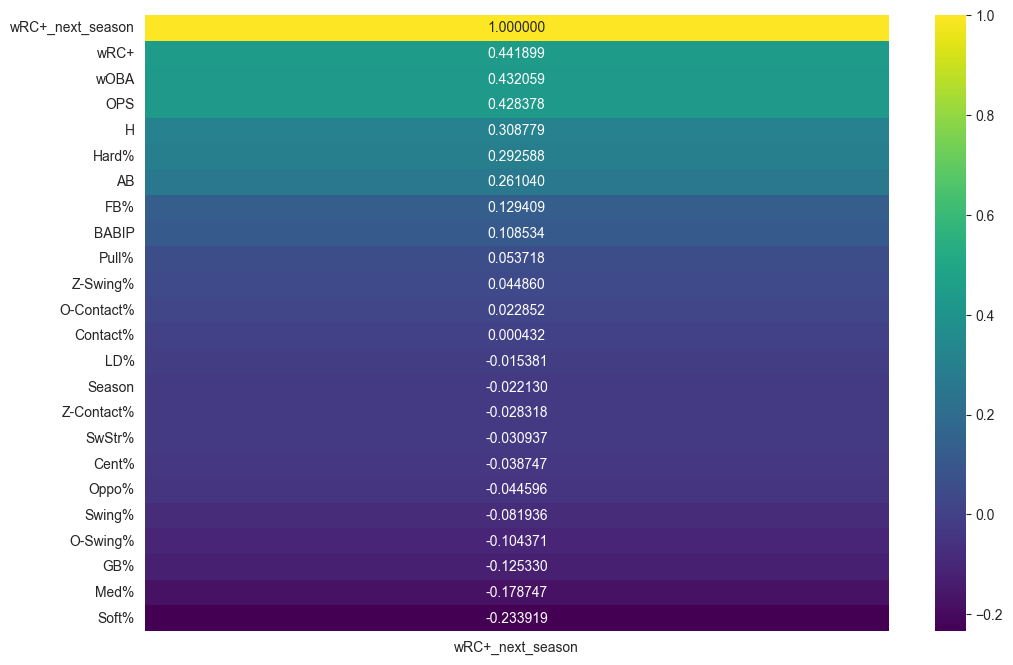

In [161]:
# correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(hits_df.corr(numeric_only=True)[['wRC+_next_season']].sort_values(by='wRC+_next_season',ascending=False),annot=True,cmap='viridis',fmt='.6f');

In [162]:
# train test split
X = hits_df.drop(['Season','Name','wRC+_next_season'],axis=1)
y = hits_df['wRC+_next_season']

print('Original Data Shape - X: {0}, y: {1}'.format(X.shape,y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train Data Shape - X; {0}, y: {1}'.format(X_train.shape,y_train.shape))
print('Test Data Shape - X: {0}, y: {1}'.format(X_test.shape,y_test.shape))

Original Data Shape - X: (2632, 22), y: (2632,)
Train Data Shape - X; (2105, 22), y: (2105,)
Test Data Shape - X: (527, 22), y: (527,)


In [163]:
# linear regression model
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [164]:
# train data average and mean absolute error
y_pred = lr.predict(X_train)

print('Average wRC+:        ',X_train['wRC+'].mean())
print('Mean absolute error: ',mean_absolute_error(y_pred,y_train))

Average wRC+:         106.34916864608076
Mean absolute error:  20.655006019955454


In [165]:
# test data average and mean absolute error
y_pred = lr.predict(X_test)

print('Average wRC+:        ',X_test['wRC+'].mean())
print('Mean absolute error: ',mean_absolute_error(y_pred,y_test))

Average wRC+:         106.25426944971537
Mean absolute error:  19.969858384988097


In [166]:
# 2022 hitting dataframe
hits_2022_df = bat_2022_df.loc[:,['Season','Name','AB','H','OPS','BABIP','wOBA','wRC+','LD%','GB%','FB%','O-Swing%','Z-Swing%','O-Contact%','Z-Contact%',
                                  'SwStr%','Contact%','Swing%','Pull%','Cent%','Oppo%','Soft%','Med%','Hard%']]
hits_2022_df['wRC+_actual'] = hits_2022_df.sort_values(['Name','Season'],ascending=False).groupby('Name')['wRC+'].shift()
hits_2022_df = hits_2022_df.loc[hits_2022_df['AB']>=300]
hits_2022_df = hits_2022_df.loc[hits_2022_df['wRC+_actual'].notnull()]

In [167]:
# split data into input feature and output
X = hits_2022_df.drop(['Season','Name','wRC+_actual'],axis=1)
y = hits_2022_df['wRC+_actual']

In [168]:
# 2022 data average and mean absolute error
y_pred = lr.predict(X)

print('Average wRC+:        ',hits_2022_df['wRC+'].mean())
print('Mean absolute error: ',mean_absolute_error(y_pred,y))

Average wRC+:         106.78733031674209
Mean absolute error:  19.2128683633117


In [169]:
# dataframe with actual wRC+ and predicted wRC+
hits_2022_df['Predicted_wRC+'] = y_pred
hits_2022_df['Season'] = 2022
hits_2022_df = hits_2022_df.rename(columns={'wRC+_actual':'Actual_wRC+'})
hits_2022_df.loc[:,['Season','Name','Actual_wRC+','Predicted_wRC+']].sort_values(by='Actual_wRC+',ascending=False).head(20)

,Season,Name,Actual_wRC+,Predicted_wRC+
41,2022,Aaron Judge,209.0,133.852027
87,2022,Yordan Alvarez,185.0,120.830354
68,2022,Paul Goldschmidt,176.0,124.709524
133,2022,Jose Altuve,164.0,112.063918
58,2022,Freddie Freeman,158.0,126.915691
164,2022,Manny Machado,153.0,115.861545
255,2022,Nolan Arenado,150.0,108.333073
443,2022,Joc Pederson,146.0,99.384394
352,2022,Yandy Diaz,146.0,114.172543
17,2022,Juan Soto,145.0,131.735461


**Classification - Decision Tree**

In [170]:
# pitching data from July 2022
pitches = statcast('2022-07-01','2022-07-31')
print('Dataset has {0} pitches'.format(len(pitches)))

This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:07<00:00,  4.38it/s]


Dataset has 114148 pitches


In [171]:
# print(pitches.columns.tolist())

In [172]:
# percentages of different types of pitches thrown
pitches['pitch_name'].value_counts(normalize=True)

pitch_name
4-Seam Fastball    0.327513
Slider             0.176963
Sinker             0.157997
Changeup           0.112722
Curveball          0.075297
Cutter             0.073194
Sweeper            0.030338
Knuckle Curve      0.022751
Split-Finger       0.015918
Slurve             0.003504
Other              0.002777
Eephus             0.000823
Slow Curve         0.000096
Pitch Out          0.000061
Knuckleball        0.000044
Name: proportion, dtype: float64

In [173]:
# pitching data with only speed, spin rate and pitch name
pitches = pitches.dropna(subset=['release_speed','release_spin_rate','pitch_name'])
pitches.shape

(113915, 92)

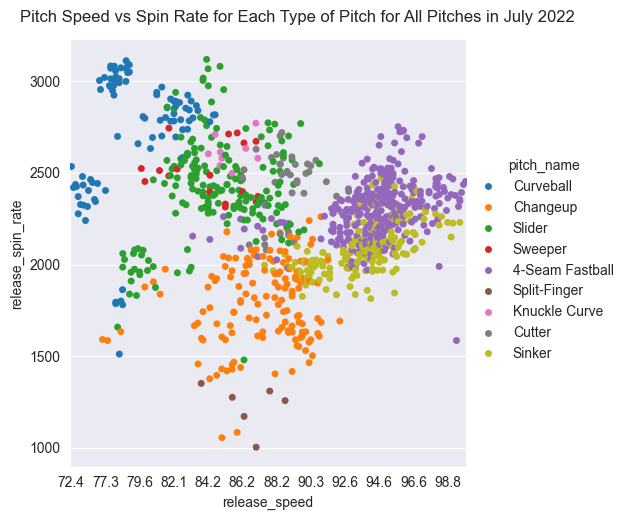

In [174]:
# catplot of pitch speed vs spin rate for each type of pitch for all pitches from July 2022
plot_pitches = sns.catplot(x='release_speed',y='release_spin_rate',hue='pitch_name',data=pitches[:1000])
plt.suptitle('Pitch Speed vs Spin Rate for Each Type of Pitch for All Pitches in July 2022',ha='center',y=1.03)

# showing every 20th xticklabel
for ind, label in enumerate(plot_pitches.ax.get_xticklabels()):
    if ind % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

In [175]:
# decision tree function
def decision_tree(data,fastball_group):
    
    # data for pitch, speed, spin rate, and velocity and acceleration in each direction
    data = data.loc[:,['pitch_name','release_speed','release_spin_rate','vx0','vy0','vz0','ax','ay','az']]
    data = data.dropna()    
    
    # group different fastballs as one fastball group
    def fastball_filter(x):
        if x == '4-Seam Fastball' or x == 'Sinker':
            return 'Fastball'
        return x
    
    # if fastball_group is True, return as fastball
    if fastball_group == True:
        data['pitch_name'] = data['pitch_name'].apply(fastball_filter)
    
    # split data into input feature and output
    X = data.loc[:,['release_speed','release_spin_rate','vx0','vy0','vz0','ax','ay','az']]
    y = data.loc[:,['pitch_name']].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # decision tree model
    dt = DecisionTreeClassifier(max_depth=20,min_samples_split=25)
    dt.fit(X_train,y_train)
    
    # print training accuracy score, testing accuracy score, and classification report
    pred = dt.predict(X_train)
    print('Train Score Accuracy: {0}'.format(accuracy_score(pred,y_train)))
    
    pred = dt.predict(X_test)
    print('Test Score Accuracy:  {0}'.format(accuracy_score(pred,y_test)))
    
    print('\n')
    print('Classification Report:')
    print(classification_report(pred,y_test))

In [176]:
# decision tree function without grouping fastballs
decision_tree(pitches,fastball_group=False)

Train Score Accuracy: 0.8911249615941711
Test Score Accuracy:  0.8095509809946012


Classification Report:
                 precision    recall  f1-score   support

4-Seam Fastball       0.92      0.91      0.91      7567
       Changeup       0.87      0.84      0.86      2685
      Curveball       0.76      0.71      0.74      1863
         Cutter       0.60      0.64      0.62      1554
         Eephus       0.55      0.85      0.67        13
  Knuckle Curve       0.35      0.50      0.41       366
          Other       0.67      0.60      0.63        65
      Pitch Out       0.00      0.00      0.00         0
         Sinker       0.82      0.84      0.83      3509
         Slider       0.79      0.77      0.78      4191
     Slow Curve       0.00      0.00      0.00         1
         Slurve       0.48      0.57      0.52        61
   Split-Finger       0.45      0.57      0.50       286
        Sweeper       0.59      0.63      0.61       622

       accuracy                     

In [177]:
# decision tree function with grouping fastballs
decision_tree(pitches,fastball_group=True)

Train Score Accuracy: 0.9125334679366194
Test Score Accuracy:  0.840670675503665


Classification Report:
               precision    recall  f1-score   support

     Changeup       0.88      0.84      0.86      2721
    Curveball       0.76      0.72      0.74      1830
       Cutter       0.57      0.60      0.59      1547
       Eephus       0.55      0.85      0.67        13
     Fastball       0.96      0.96      0.96     11032
Knuckle Curve       0.40      0.50      0.45       415
  Knuckleball       0.00      0.00      0.00         1
        Other       0.50      0.50      0.50        58
    Pitch Out       0.00      0.00      0.00         1
       Slider       0.78      0.75      0.77      4192
   Slow Curve       0.00      0.00      0.00         1
       Slurve       0.49      0.58      0.53        62
 Split-Finger       0.44      0.56      0.49       285
      Sweeper       0.57      0.61      0.59       625

     accuracy                           0.84     22783
    macro av

Grouping different fastballs into one group improves the predicting accuracy of this model. Testing accuracy improves from 80.9% to 84.6%. Grouping fastball improves the f1-score to 96% from a 4-seam fastball f1-score of 92% and a sinker f1-score of 83%.

In [178]:
# Kershaw pitching data from 2018-2022
kershaw_pitching = statcast_pitcher('2018-03-29','2022-10-05',477132)
print('Dataset has {0} pitches'.format(len(kershaw_pitching)))

Gathering Player Data
Dataset has 10796 pitches


In [179]:
# decision tree function without grouping fastballs
decision_tree(kershaw_pitching,fastball_group=False)

Train Score Accuracy: 0.9915632156201036
Test Score Accuracy:  0.9797590361445783


Classification Report:
                 precision    recall  f1-score   support

4-Seam Fastball       0.98      0.97      0.98       868
       Changeup       0.91      1.00      0.95        10
      Curveball       1.00      1.00      1.00       316
         Sinker       0.00      0.00      0.00         0
         Slider       0.97      0.98      0.98       881

       accuracy                           0.98      2075
      macro avg       0.77      0.79      0.78      2075
   weighted avg       0.98      0.98      0.98      2075



In [180]:
# decision tree function with grouping fastball
decision_tree(kershaw_pitching,fastball_group=True)

Train Score Accuracy: 0.992286368566952
Test Score Accuracy:  0.9797590361445783


Classification Report:
              precision    recall  f1-score   support

    Changeup       0.91      1.00      0.95        10
   Curveball       1.00      1.00      1.00       316
    Fastball       0.98      0.97      0.98       868
      Slider       0.97      0.98      0.98       881

    accuracy                           0.98      2075
   macro avg       0.97      0.99      0.98      2075
weighted avg       0.98      0.98      0.98      2075



Predicting accuracy for Kershaw's pitches improves insignificantly with grouping fastballs since the 4-seam fastball is the only type of fastball he throws.

In [181]:
# Alcantara pitching data from 2019-2022
alcantara_pitching = statcast_pitcher('2019-03-20','2022-10-05',645261)
print('Dataset has {0} pitches'.format(len(alcantara_pitching)))

Gathering Player Data
Dataset has 10889 pitches


In [182]:
# decision tree function without grouping fastballs
decision_tree(alcantara_pitching,fastball_group=False)

Train Score Accuracy: 0.9837141183362624
Test Score Accuracy:  0.96485473289597


Classification Report:
                 precision    recall  f1-score   support

4-Seam Fastball       0.99      0.98      0.98       561
       Changeup       0.96      0.95      0.95       443
      Curveball       0.89      0.89      0.89        76
         Sinker       0.94      0.97      0.95       588
         Slider       0.98      0.98      0.98       466

       accuracy                           0.96      2134
      macro avg       0.95      0.95      0.95      2134
   weighted avg       0.97      0.96      0.96      2134



In [183]:
# decision tree function with grouping fastballs
decision_tree(alcantara_pitching,fastball_group=True)

Train Score Accuracy: 0.9876977152899824
Test Score Accuracy:  0.9770384254920338


Classification Report:
              precision    recall  f1-score   support

    Changeup       0.98      0.95      0.96       447
   Curveball       0.89      0.89      0.89        76
    Fastball       0.98      0.99      0.99      1148
   Pitch Out       0.00      0.00      0.00         1
      Slider       0.98      0.98      0.98       462

    accuracy                           0.98      2134
   macro avg       0.77      0.76      0.77      2134
weighted avg       0.98      0.98      0.98      2134



Alcantara throws about an even number of 4-seam fastballs and sinkers. Predicting accuracy on classifying his pitches improves slightly with grouping fastballs together improving to an f1-score of 99%.

### Web Scraping

**Baseball Almanac Data**

In [118]:
# https://stackoverflow.com/questions/38489386/python-requests-403-forbidden
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

# request to scrape the website page
lad_response = requests.get('https://www.baseball-almanac.com/opening_day/odschedule.php?t=LAN',headers=headers)
# print(lad_response.text)

In [119]:
# parse HTML into BS data
lad_soup = BS(lad_response.text)

# find all tables
tables = lad_soup.find_all('table')
len(tables)

2

In [123]:
# nested tag
lad_table = tables[0]

# find all table rows
rows = lad_table.find_all('tr')
rows[2]

<tr>
<td class="datacolBoxC">1</td>
<td class="datacolBoxC">05-05-1884</td>
<td class="datacolBox"><a href="../teamstats/schedule.php?y=1884&amp;t=WS7" title="Opponent Schedule">vs Washington Nationals</a></td>
<td class="datacolBoxC">11-3</td>
<td class="datacolBoxC">W</td>
<td class="datacolBoxC">1-0</td>
</tr>

In [124]:
# nested tag
first_data_row = rows[2]

# find all table data
first_data_row.find_all('td')

[<td class="datacolBoxC">1</td>,
 <td class="datacolBoxC">05-05-1884</td>,
 <td class="datacolBox"><a href="../teamstats/schedule.php?y=1884&amp;t=WS7" title="Opponent Schedule">vs Washington Nationals</a></td>,
 <td class="datacolBoxC">11-3</td>,
 <td class="datacolBoxC">W</td>,
 <td class="datacolBoxC">1-0</td>]

In [125]:
# get data out in the form of a list of strings
[str(x.string) for x in first_data_row.find_all('td')]

['1', '05-05-1884', 'vs Washington Nationals', '11-3', 'W', '1-0']

In [134]:
# parse row function that takes in a tr tag and get the data out of it in the form of a list of strings
def parse_row(row):
    return [str(x.string) for x in row.find_all('td')]

In [138]:
# put results of parse_row function into a list then into a dataframe
parsed_row_list = [parse_row(row) for row in rows[2:-2]]
ba_df = pd.DataFrame(parsed_row_list,columns=parse_row(rows[1]))
ba_df.tail(10)

,Opening Day,Date / Box Score,Opponent,Score,Decision,Record
130,131,04-04-2014,vs San Francisco Giants,4-8,L,65-62-4
131,132,04-06-2015,vs San Diego Padres,6-3,W,66-62-4
132,133,04-12-2016,vs Arizona Diamondbacks,2-4,L,66-63-4
133,134,04-03-2017,vs San Diego Padres,14-3,W,67-63-4
134,135,03-29-2018,vs San Francisco Giants,0-1,L,67-64-4
135,136,03-28-2019,vs Arizona Diamondbacks,12-5,W,68-64-4
136,137,07-23-2020,vs San Francisco Giants,8-1,W,69-64-4
137,138,04-09-2021,vs Washington Nationals,1-0,W,70-64-4
138,139,04-14-2022,vs Cincinnati Reds,9-3,W,71-64-4
139,140,03-30-2023,vs Arizona Diamondbacks,8-2,W,72-64-4


In [144]:
# function that takes a team and scrapes opening day games
def opening_day_single_team(team):
    team_response = requests.get(f'https://www.baseball-almanac.com/opening_day/odschedule.php?t={team}',headers=headers)
    team_soup = BS(team_response.text)
    
    tables = team_soup.find_all('table')
    
    team_table = tables[0]
    rows = team_table.find_all('tr')
    
    parsed_row_list = [parse_row(row) for row in rows[2:-2]]
    
    ba_df = pd.DataFrame(parsed_row_list,columns=parse_row(rows[1]))
    ba_df['team'] = team
    
    return ba_df

In [145]:
# use opening_day_single_team function to get dataframe of all NY Yankees opening day games
yankees_df = opening_day_single_team('NYA')
yankees_df.tail(10)

,Opening Day,Date / Box Score,Opponent,Score,Decision,Record,team
113,114,04-07-2014,vs Baltimore Orioles,4-2,W,76-37-1,NYA
114,115,04-06-2015,vs Toronto Blue Jays,1-6,L,76-38-1,NYA
115,116,04-05-2016,vs Houston Astros,3-5,L,76-39-1,NYA
116,117,04-10-2017,vs Tampa Bay Rays,8-1,W,77-39-1,NYA
117,118,04-03-2018,vs Tampa Bay Rays,11-4,W,78-39-1,NYA
118,119,03-28-2019,vs Baltimore Orioles,7-2,W,79-39-1,NYA
119,120,07-31-2020,vs Boston Red Sox,5-1,W,80-39-1,NYA
120,121,04-01-2021,vs Toronto Blue Jays,2-3,L,80-40-1,NYA
121,122,04-08-2022,vs Boston Red Sox,6-5,W,81-40-1,NYA
122,123,03-30-2023,vs San Francisco Giants,5-0,W,82-40-1,NYA


In [146]:
# use opening_day_single_team function to get dataframe of all LA Dodgers opening day games
dodgers_df = opening_day_single_team('LAN')
dodgers_df.tail(10)

,Opening Day,Date / Box Score,Opponent,Score,Decision,Record,team
130,131,04-04-2014,vs San Francisco Giants,4-8,L,65-62-4,LAN
131,132,04-06-2015,vs San Diego Padres,6-3,W,66-62-4,LAN
132,133,04-12-2016,vs Arizona Diamondbacks,2-4,L,66-63-4,LAN
133,134,04-03-2017,vs San Diego Padres,14-3,W,67-63-4,LAN
134,135,03-29-2018,vs San Francisco Giants,0-1,L,67-64-4,LAN
135,136,03-28-2019,vs Arizona Diamondbacks,12-5,W,68-64-4,LAN
136,137,07-23-2020,vs San Francisco Giants,8-1,W,69-64-4,LAN
137,138,04-09-2021,vs Washington Nationals,1-0,W,70-64-4,LAN
138,139,04-14-2022,vs Cincinnati Reds,9-3,W,71-64-4,LAN
139,140,03-30-2023,vs Arizona Diamondbacks,8-2,W,72-64-4,LAN


### MLB API

In [24]:
# get data from url
teams_url = 'https://statsapi.mlb.com/api/v1/teams'
teams_resp = requests.get(teams_url)
teams_json = teams_resp.json()

In [25]:
teams_json.keys()

dict_keys(['copyright', 'teams'])

In [26]:
len(teams_json['teams'])

706

In [27]:
teams_json['teams'][0]

{'allStarStatus': 'N',
 'id': 4124,
 'name': 'Pensacola Blue Wahoos',
 'link': '/api/v1/teams/4124',
 'season': 2023,
 'venue': {'id': 4329,
  'name': 'Blue Wahoos Stadium',
  'link': '/api/v1/venues/4329'},
 'teamCode': 'pen',
 'fileCode': 't4124',
 'abbreviation': 'PNS',
 'teamName': 'Blue Wahoos',
 'locationName': 'Pensacola',
 'firstYearOfPlay': '2012',
 'league': {'id': 111,
  'name': 'Southern League',
  'link': '/api/v1/league/111'},
 'division': {'id': 240,
  'name': 'Southern League South',
  'link': '/api/v1/divisions/240'},
 'sport': {'id': 12, 'link': '/api/v1/sports/12', 'name': 'Double-A'},
 'shortName': 'Pensacola',
 'parentOrgName': 'Miami Marlins',
 'parentOrgId': 146,
 'franchiseName': 'Pensacola',
 'clubName': 'Blue Wahoos',
 'active': True}

In [72]:
# dictionary without nested fields
team = teams_json['teams'][0]

team_flat = {key: value for key, value in team.items() if type(value) is not dict}
team_flat

{'allStarStatus': 'N',
 'id': 4124,
 'name': 'Pensacola Blue Wahoos',
 'link': '/api/v1/teams/4124',
 'season': 2023,
 'teamCode': 'pen',
 'fileCode': 't4124',
 'abbreviation': 'PNS',
 'teamName': 'Blue Wahoos',
 'locationName': 'Pensacola',
 'firstYearOfPlay': '2012',
 'shortName': 'Pensacola',
 'parentOrgName': 'Miami Marlins',
 'parentOrgId': 146,
 'franchiseName': 'Pensacola',
 'clubName': 'Blue Wahoos',
 'active': True}

In [73]:
# flatten nested fields into dictionary
team_flat['venueId'] = team['venue']['id']
team_flat['venueName'] = team['venue']['name']
team_flat['leagueId'] = team['league']['id']
team_flat['leagueName'] = team['league']['name']
team_flat['divisionId'] = team['division']['id']
team_flat['divisionName'] = team['division']['name']
team_flat['sportId'] = team['sport']['id']
team_flat['sportName'] = team['sport']['name']

In [74]:
team_flat

{'allStarStatus': 'N',
 'id': 4124,
 'name': 'Pensacola Blue Wahoos',
 'link': '/api/v1/teams/4124',
 'season': 2023,
 'teamCode': 'pen',
 'fileCode': 't4124',
 'abbreviation': 'PNS',
 'teamName': 'Blue Wahoos',
 'locationName': 'Pensacola',
 'firstYearOfPlay': '2012',
 'shortName': 'Pensacola',
 'parentOrgName': 'Miami Marlins',
 'parentOrgId': 146,
 'franchiseName': 'Pensacola',
 'clubName': 'Blue Wahoos',
 'active': True,
 'venueId': 4329,
 'venueName': 'Blue Wahoos Stadium',
 'leagueId': 111,
 'leagueName': 'Southern League',
 'divisionId': 240,
 'divisionName': 'Southern League South',
 'sportId': 12,
 'sportName': 'Double-A'}

In [75]:
# flatten_team function to flatten nested fields into dictionary
def flatten_team(nested):
    flat = {key: value for key, value in nested.items() if type(value) is not dict}
    
    flat['venueId'] = nested.get('venue',{}).get('id')
    flat['venueName'] = nested.get('league',{}).get('name')
    flat['leagueId'] = nested.get('league',{}).get('id')
    flat['leagueName'] = nested.get('league',{}).get('name')
    flat['divisionId'] = nested.get('division',{}).get('id')
    flat['divisionName'] = nested.get('division',{}).get('name')
    flat['sportId'] = nested.get('sport',{}).get('id')
    flat['sportName'] = nested.get('sport',{}).get('name')
    
    return flat
    

In [76]:
# flattened dictionary into dataframe
teams_df = pd.DataFrame([flatten_team(x) for x in teams_json['teams']])
teams_df.head()

,allStarStatus,id,name,link,season,teamCode,fileCode,abbreviation,teamName,locationName,...,clubName,active,venueId,venueName,leagueId,leagueName,divisionId,divisionName,sportId,sportName
0,N,4124,Pensacola Blue Wahoos,/api/v1/teams/4124,2023,pen,t4124,PNS,Blue Wahoos,Pensacola,...,Blue Wahoos,True,4329,Southern League,111.0,Southern League,240.0,Southern League South,12,Double-A
1,N,4144,Ohio State Buckeyes,/api/v1/teams/4144,2023,osb,t4144,OSU,Buckeyes,United States,...,Buckeyes,True,401,College Baseball,107.0,College Baseball,NaN,None,22,College Baseball
2,N,2101,DSL Brewers 2,/api/v1/teams/2101,2023,brc,t2101,DSL BRW2,DSL Brewers 2,United States,...,DSL Brewers 2,True,401,Dominican Summer League,130.0,Dominican Summer League,247.0,Dominican Summer League North,16,Rookie
3,N,3130,DSL Orioles Orange,/api/v1/teams/3130,2023,dba,t3130,DSL ORIO,DSL Orioles Orange,United States,...,DSL Orioles Orange,True,401,Dominican Summer League,130.0,Dominican Summer League,250.0,Dominican Summer League Baseball City,16,Rookie
4,N,4164,Monmouth Hawks,/api/v1/teams/4164,2011,mou,t4164,MON,Hawks,United States,...,Hawks,True,401,College Baseball,107.0,College Baseball,NaN,None,22,College Baseball


In [78]:
# all the different baseball leagues
teams_df['leagueName'].value_counts()

College Baseball                                153
Dominican Summer League                          50
Showcase Games                                   42
Extended Spring Training                         30
World Baseball Classic                           20
International League                             20
Mexican League                                   18
Arizona Complex League                           17
Florida Complex League                           15
American League                                  15
National League                                  15
Northern League                                  13
Carolina League                                  12
South Atlantic League                            12
Eastern League                                   12
Midwest League                                   12
Texas League                                     10
Appalachian League                               10
Liga Mexicana del Pacifico                       10
Atlantic Lea

In [79]:
# MLB teams dataframe
mlb_df = teams_df.loc[((teams_df['leagueName']=='American League') | 
                       (teams_df['leagueName']=='National League'))]
mlb_df.head()

,allStarStatus,id,name,link,season,teamCode,fileCode,abbreviation,teamName,locationName,...,clubName,active,venueId,venueName,leagueId,leagueName,divisionId,divisionName,sportId,sportName
18,N,108,Los Angeles Angels,/api/v1/teams/108,2023,ana,ana,LAA,Angels,Anaheim,...,Angels,True,1,American League,103.0,American League,200.0,American League West,1,Major League Baseball
19,N,109,Arizona Diamondbacks,/api/v1/teams/109,2023,ari,ari,AZ,D-backs,Phoenix,...,Diamondbacks,True,15,National League,104.0,National League,203.0,National League West,1,Major League Baseball
20,N,110,Baltimore Orioles,/api/v1/teams/110,2023,bal,bal,BAL,Orioles,Baltimore,...,Orioles,True,2,American League,103.0,American League,201.0,American League East,1,Major League Baseball
21,N,111,Boston Red Sox,/api/v1/teams/111,2023,bos,bos,BOS,Red Sox,Boston,...,Red Sox,True,3,American League,103.0,American League,201.0,American League East,1,Major League Baseball
22,N,112,Chicago Cubs,/api/v1/teams/112,2023,chn,chc,CHC,Cubs,Chicago,...,Cubs,True,17,National League,104.0,National League,205.0,National League Central,1,Major League Baseball


In [81]:
# all columns in dataframe
print(mlb_df.columns.tolist())

['allStarStatus', 'id', 'name', 'link', 'season', 'teamCode', 'fileCode', 'abbreviation', 'teamName', 'locationName', 'firstYearOfPlay', 'shortName', 'parentOrgName', 'parentOrgId', 'franchiseName', 'clubName', 'active', 'venueId', 'venueName', 'leagueId', 'leagueName', 'divisionId', 'divisionName', 'sportId', 'sportName']


In [82]:
mlb_df[['id','name','leagueId','leagueName','divisionId','divisionName','sportId','sportName']]

,id,name,leagueId,leagueName,divisionId,divisionName,sportId,sportName
18,108,Los Angeles Angels,103.0,American League,200.0,American League West,1,Major League Baseball
19,109,Arizona Diamondbacks,104.0,National League,203.0,National League West,1,Major League Baseball
20,110,Baltimore Orioles,103.0,American League,201.0,American League East,1,Major League Baseball
21,111,Boston Red Sox,103.0,American League,201.0,American League East,1,Major League Baseball
22,112,Chicago Cubs,104.0,National League,205.0,National League Central,1,Major League Baseball
23,113,Cincinnati Reds,104.0,National League,205.0,National League Central,1,Major League Baseball
24,114,Cleveland Guardians,103.0,American League,202.0,American League Central,1,Major League Baseball
25,115,Colorado Rockies,104.0,National League,203.0,National League West,1,Major League Baseball
26,116,Detroit Tigers,103.0,American League,202.0,American League Central,1,Major League Baseball
27,117,Houston Astros,103.0,American League,200.0,American League West,1,Major League Baseball


In [83]:
# get roster data from url
rosters_url = 'https://statsapi.mlb.com/api/v1/teams/119/roster'
rosters_resp = requests.get(rosters_url)
rosters_json = rosters_resp.json()

In [84]:
rosters_json.keys()

dict_keys(['copyright', 'roster', 'link', 'teamId', 'rosterType'])

In [88]:
rosters_json['roster'][7]

{'person': {'id': 477132,
  'fullName': 'Clayton Kershaw',
  'link': '/api/v1/people/477132'},
 'jerseyNumber': '22',
 'position': {'code': '1',
  'name': 'Pitcher',
  'type': 'Pitcher',
  'abbreviation': 'P'},
 'status': {'code': 'A', 'description': 'Active'},
 'parentTeamId': 119}

In [92]:
# flatten nested fields into dictionary
ck_flat = {}
ck_flat['personId'] = ck.get('person',{}).get('id')
ck_flat['name'] = ck.get('person',{}).get('fullName')
ck_flat['jerseyNumber'] = ck.get('jerseyNumber')
ck_flat['position'] = ck.get('position',{}).get('name')
ck_flat['active'] = ck.get('status',{}).get('description')

In [93]:
ck_flat

{'personId': 477132,
 'name': 'Clayton Kershaw',
 'jerseyNumber': '22',
 'position': 'Pitcher',
 'active': 'Active'}

In [95]:
# flatten_player function to flatten nested fields into dictionary
def flatten_player(nested):
    flat = {}
    
    flat['personId'] = nested.get('person',{}).get('id')
    flat['name'] = nested.get('person',{}).get('fullName')
    flat['jerseyNumber'] = nested.get('jerseyNumber')
    flat['position'] = nested.get('position',{}).get('name')
    flat['active'] = nested.get('status',{}).get('description')
    
    return flat

In [96]:
# flattened dictionary into dataframe
dodgers_roster_flat = [flatten_player(x) for x in rosters_json['roster']]

dodgers_roster_df = pd.DataFrame(dodgers_roster_flat)
dodgers_roster_df.head()

,personId,name,jerseyNumber,position,active
0,592473,Adam Kolarek,56,Pitcher,Active
1,681911,Alex Vesia,51,Pitcher,Active
2,605131,Austin Barnes,15,Catcher,Active
3,676272,Bobby Miller,70,Pitcher,Active
4,660813,Brusdar Graterol,48,Pitcher,Active


In [97]:
# team_roster function to create roster dataframe of team
def team_roster(team_id):
    rosters_url = f'https://statsapi.mlb.com/api/v1/teams/{team_id}/roster'
    rosters_resp = requests.get(rosters_url)
    rosters_json = rosters_resp.json()
    
    rosters_flat = [flatten_player(x) for x in rosters_json['roster']]
    team_roster_df = pd.DataFrame(rosters_flat)
    team_roster_df['teamId'] = team_id
    
    return team_roster_df

In [99]:
angels_roster_df = team_roster(108)
angels_roster_df.head(10)

,personId,name,jerseyNumber,position,active,teamId
0,571901,Aaron Loup,28,Pitcher,Active,108
1,543685,Anthony Rendon,6,Third Base,Active,108
2,592273,Brandon Drury,23,Second Base,Active,108
3,608032,Carlos Estevez,53,Pitcher,Active,108
4,595453,Chad Wallach,35,Catcher,Active,108
5,606965,Chris Devenski,49,Pitcher,Active,108
6,570482,Gio Urshela,10,Third Base,Active,108
7,656288,Griffin Canning,47,Pitcher,Active,108
8,592669,Hunter Renfroe,12,Outfielder,Active,108
9,657097,Jacob Webb,71,Pitcher,Active,108
